# ML Bidding Engine (Loveholidays Take Home Task)

 Robert Gregorio | Data Science Interview Take Home Test |dr.rgregorio@pm.me |

## Load Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from pandas.tseries.offsets import BMonthEnd
import matplotlib.dates as mdates
import optuna
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from datetime import datetime

## Data Loading

In [2]:
df = pd.read_feather('bidding_data.feather')

## Data Cleaning

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AdGroupId,1149066.0,1.434031e+11,1.988048e+09,1.407453e+11,1.422845e+11,1.436658e+11,1.438699e+11,1.490543e+11
KeywordId,1149066.0,5.770803e+11,5.989252e+11,1.034167e+07,1.789831e+10,3.228174e+11,1.223696e+12,1.906812e+12
CpcBid,1149066.0,1.390638e+00,8.351394e-01,2.400000e-02,7.920000e-01,1.296000e+00,1.812000e+00,1.380000e+01
AbsoluteTopImpressionPercentage,1149066.0,2.264755e-01,3.456469e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.290000e-01,1.000000e+00
TopImpressionPercentage,1149066.0,4.863598e-01,4.834229e-01,0.000000e+00,0.000000e+00,5.400000e-01,1.000000e+00,1.000000e+00
SearchImpressionShare,1149066.0,1.060965e-01,2.758422e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Impressions,1149066.0,3.636805e+01,2.362846e+02,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+01,2.580200e+04
Clicks,1149066.0,3.440344e+00,2.620126e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.204000e+03
Cost,1149066.0,3.797655e+00,3.376375e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.532160e+00,3.327235e+03
Margin,1149066.0,1.988234e+00,2.745535e+01,-5.114016e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.409368e+03


In [4]:
# Add ROI 
df['ROI'] = df['Margin'] / df['Cost'] 

# Replace NaN cases with 0 since cost = 0
df.fillna(0, inplace=True)

# Replace inf cases where cost is zero but margin is non-zero
df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf values with NaN
df = df.dropna(subset=['ROI'])  # Drop rows with NaN values in the ROI column

# Convert 'KeywordId' to str as CatBoost works with string type categorical features
df['KeywordId'] = df['KeywordId'].astype(str)

# Check if any samples in the dataset are empty
print(df.isnull().sum())

df.head()

AdGroupId                          0
KeywordId                          0
Keyword                            0
Date                               0
CpcBid                             0
AbsoluteTopImpressionPercentage    0
TopImpressionPercentage            0
SearchImpressionShare              0
Impressions                        0
Clicks                             0
Cost                               0
Margin                             0
ROI                                0
dtype: int64


,AdGroupId,KeywordId,Keyword,Date,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,Impressions,Clicks,Cost,Margin,ROI
0,143665864253,301448549744,hen weekends abroad,2022-09-15,2.292,0.000,0.000,0.0,0,0,0.00000,0.0,0.0
1,146372247960,1713432234206,holidays2024,2022-09-15,0.768,0.000,0.000,0.0,0,0,0.00000,0.0,0.0
2,143665839733,364851922036,+beach +luxury +holidays,2022-09-15,3.348,0.520,0.960,0.0,38,0,0.00000,0.0,0.0
3,146372231240,306355270770,+august +vacations,2022-09-15,3.600,0.754,0.996,0.0,44,2,0.00000,0.0,0.0
4,146372229320,19131834622,warm holidays in october,2022-09-15,3.756,0.780,1.000,0.0,56,4,6.79836,0.0,0.0


## Data Exploration

In this section understanding the structure of the data, checking the types of data and preliminary statistics of the dataset.


### Understanding AdgroupIds, KeywordIds and unique keyword combinations

In [5]:
# How many groupIds
unique_adgroupids = df['AdGroupId'].nunique()
print(f'There are {unique_adgroupids} unique AdGroupIds.')

# How many KeywordIds
unique_keywordid = df['KeywordId'].nunique()
print(f'There are {unique_keywordid} unique KeywordId.')

#  How many unique keyword combinations
unique_keyword_combinations = df.groupby(['AdGroupId', 'KeywordId']).ngroups
print(f'There are {unique_keyword_combinations} unique keyword combinations.')

# Check if the number of unique 'KeywordId' in the DataFrame is the same as 
# the number of rows in the DataFrame grouped by 'AdGroupId' and 'KeywordId'
assert df['KeywordId'].nunique() == df.groupby(['AdGroupId', 'KeywordId']).ngroups


There are 1625 unique AdGroupIds.
There are 4391 unique KeywordId.
There are 4391 unique keyword combinations.


### Histogram - Raw data

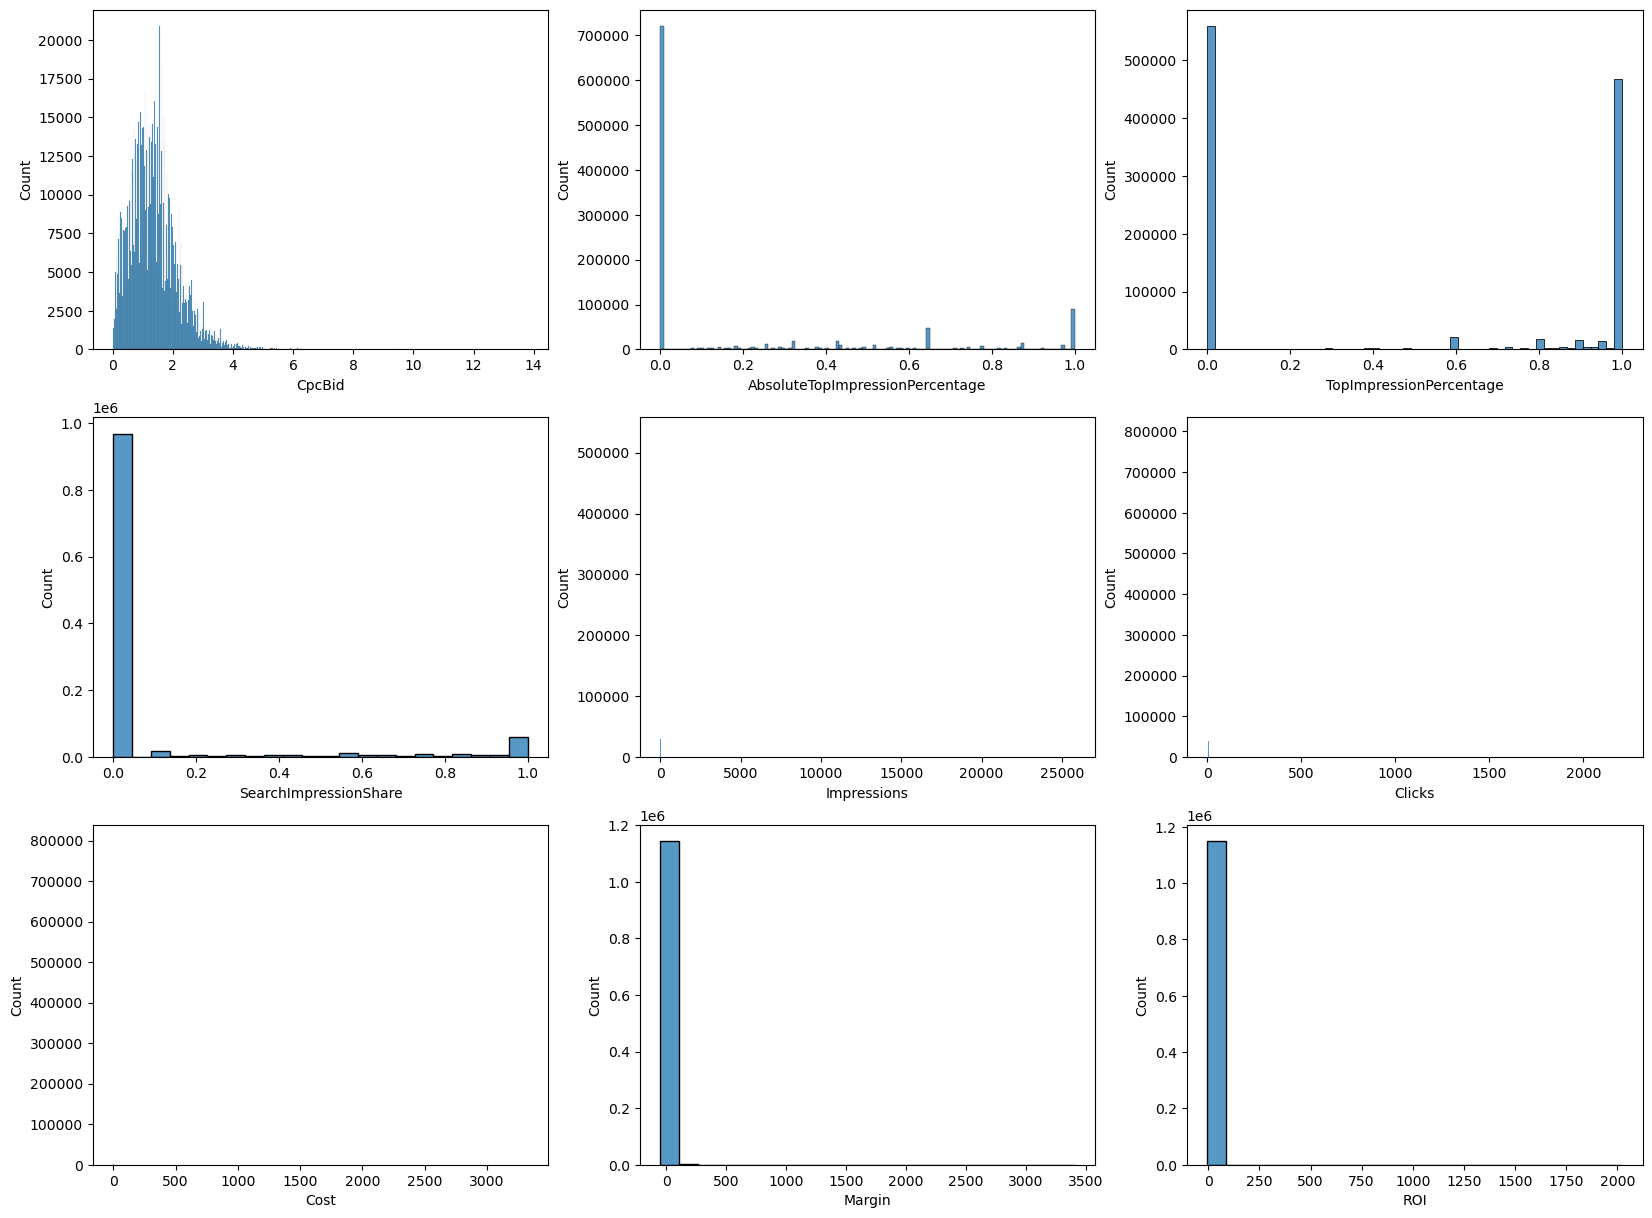

In [6]:
#Raw data histogram

fig, ax = plt.subplots(3, 3, figsize=(20, 15))  # adjusted to a 3x3 grid
sns.histplot(df['CpcBid'], ax=ax[0, 0])
sns.histplot(df['AbsoluteTopImpressionPercentage'], ax=ax[0, 1])
sns.histplot(df['TopImpressionPercentage'], ax=ax[0, 2])
sns.histplot(df['SearchImpressionShare'], ax=ax[1, 0])
sns.histplot(df['Impressions'], ax=ax[1, 1])
sns.histplot(df['Clicks'], ax=ax[1, 2])
sns.histplot(df['Cost'], ax=ax[2, 0])
sns.histplot(df['Margin'], ax=ax[2, 1])
sns.histplot(df['ROI'], ax=ax[2, 2])

plt.show()

### Histogram - Non zero data 

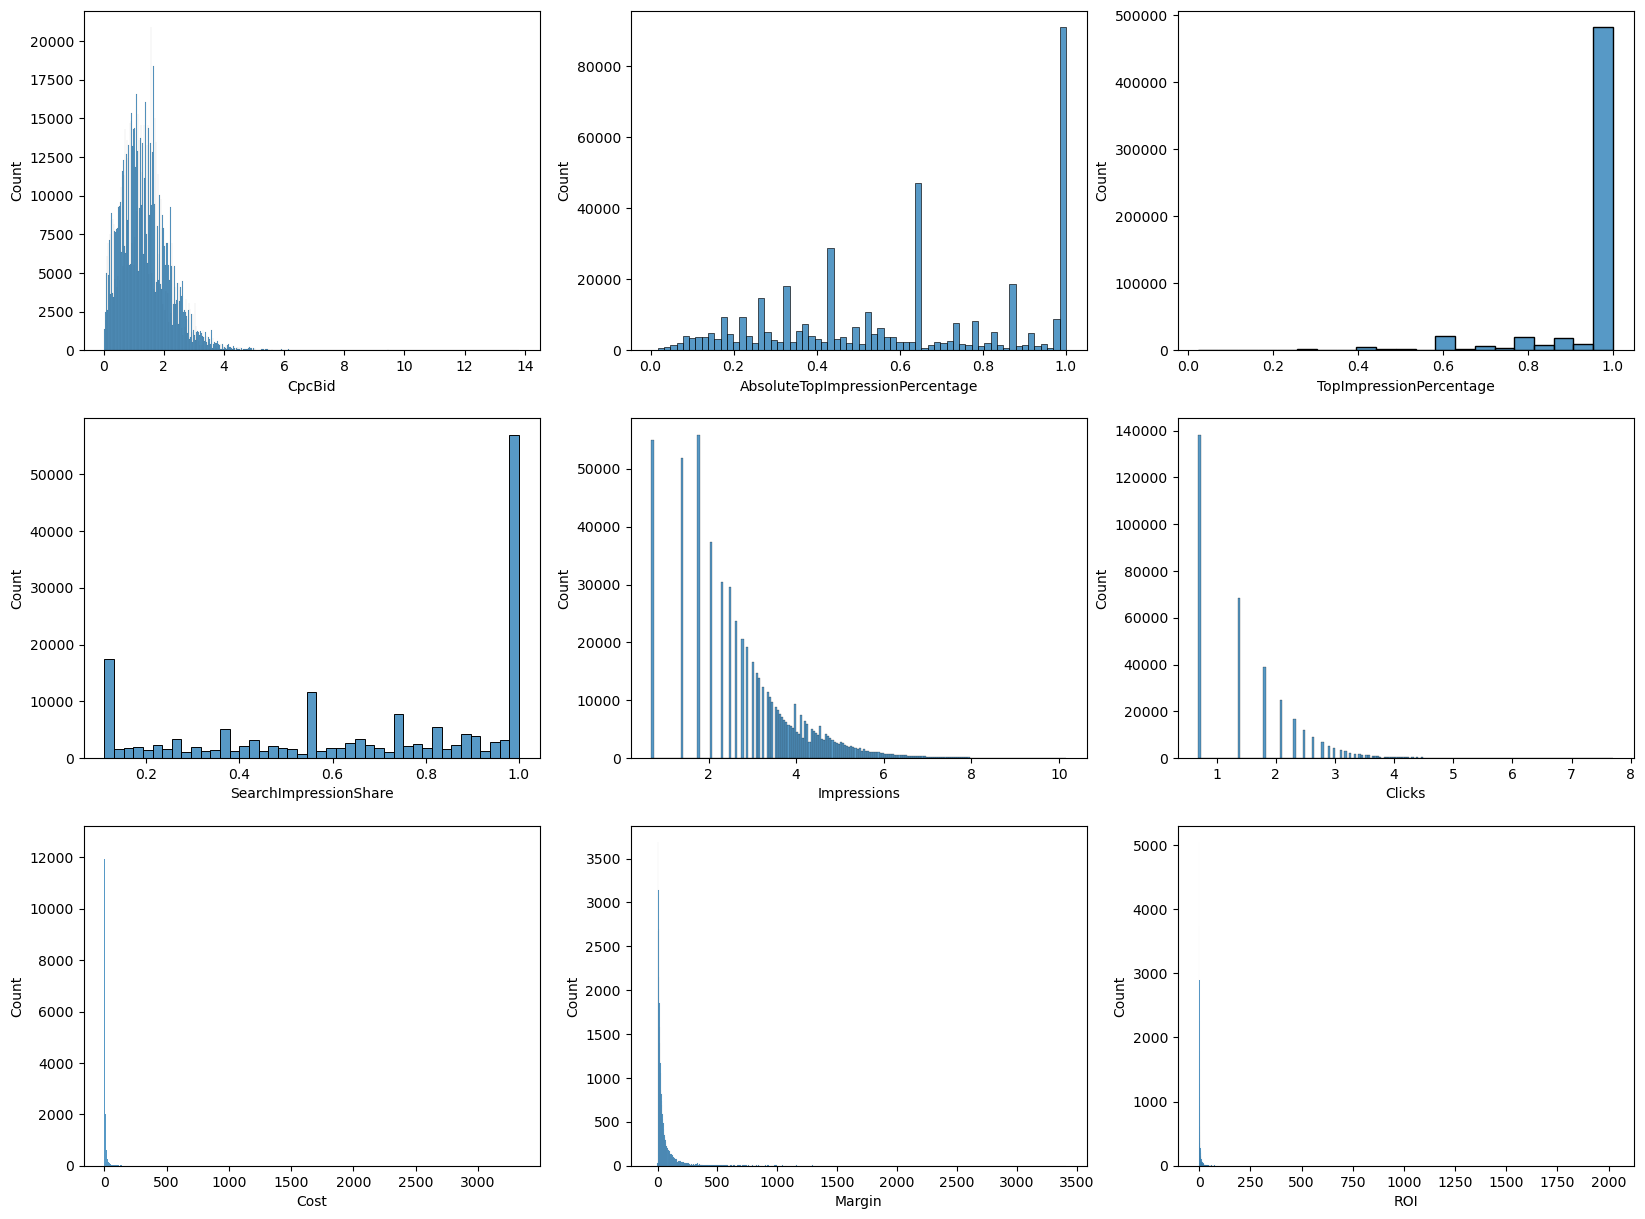

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))  # adjusted to a 3x3 grid
sns.histplot(df[df['CpcBid'] > 0]['CpcBid'], ax=ax[0, 0])
sns.histplot(df[df['AbsoluteTopImpressionPercentage'] > 0]['AbsoluteTopImpressionPercentage'], ax=ax[0, 1])
sns.histplot(df[df['TopImpressionPercentage'] > 0]['TopImpressionPercentage'], ax=ax[0, 2])
sns.histplot(df[df['SearchImpressionShare'] > 0]['SearchImpressionShare'], ax=ax[1, 0])
sns.histplot(np.log(df.loc[df['Impressions'] > 0, 'Impressions']), ax=ax[1, 1])  # Apply log transformation here
sns.histplot(np.log(df.loc[df['Clicks'] > 0, 'Clicks']), ax=ax[1, 2])  # Apply log transformation here
sns.histplot(df[df['Cost'] > 0]['Cost'], ax=ax[2, 0])
sns.histplot(df[df['Margin'] != 0]['Margin'], ax=ax[2, 1])  # Margin can be negative
sns.histplot(df[df['ROI'] != 0]['ROI'], ax=ax[2, 2])  # ROI can be negative (?)

plt.show()


### Linear relationships - Clicks

In [ ]:
# Linear Relationships - Clicks
fig, ax = plt.subplots(3, 3, figsize=(20, 15))  # adjusted to a 3x3 grid
sns.scatterplot(x=df['CpcBid'], y=df['Clicks'], ax=ax[0, 0])
sns.scatterplot(x=df['AbsoluteTopImpressionPercentage'], y=df['Clicks'], ax=ax[0, 1])
sns.scatterplot(x=df['TopImpressionPercentage'], y=df['Clicks'], ax=ax[0, 2])
sns.scatterplot(x=df['SearchImpressionShare'], y=df['Clicks'], ax=ax[1, 0])
sns.scatterplot(x=df['Impressions'], y=df['Clicks'], ax=ax[1, 1])
sns.scatterplot(x=df['Cost'], y=df['Clicks'], ax=ax[1, 2])
sns.scatterplot(x=df['Margin'], y=df['Clicks'], ax=ax[2, 0])
sns.scatterplot(x=df['ROI'], y=df['Clicks'], ax=ax[2, 1])
plt.show()

### Linear relationships - ROI

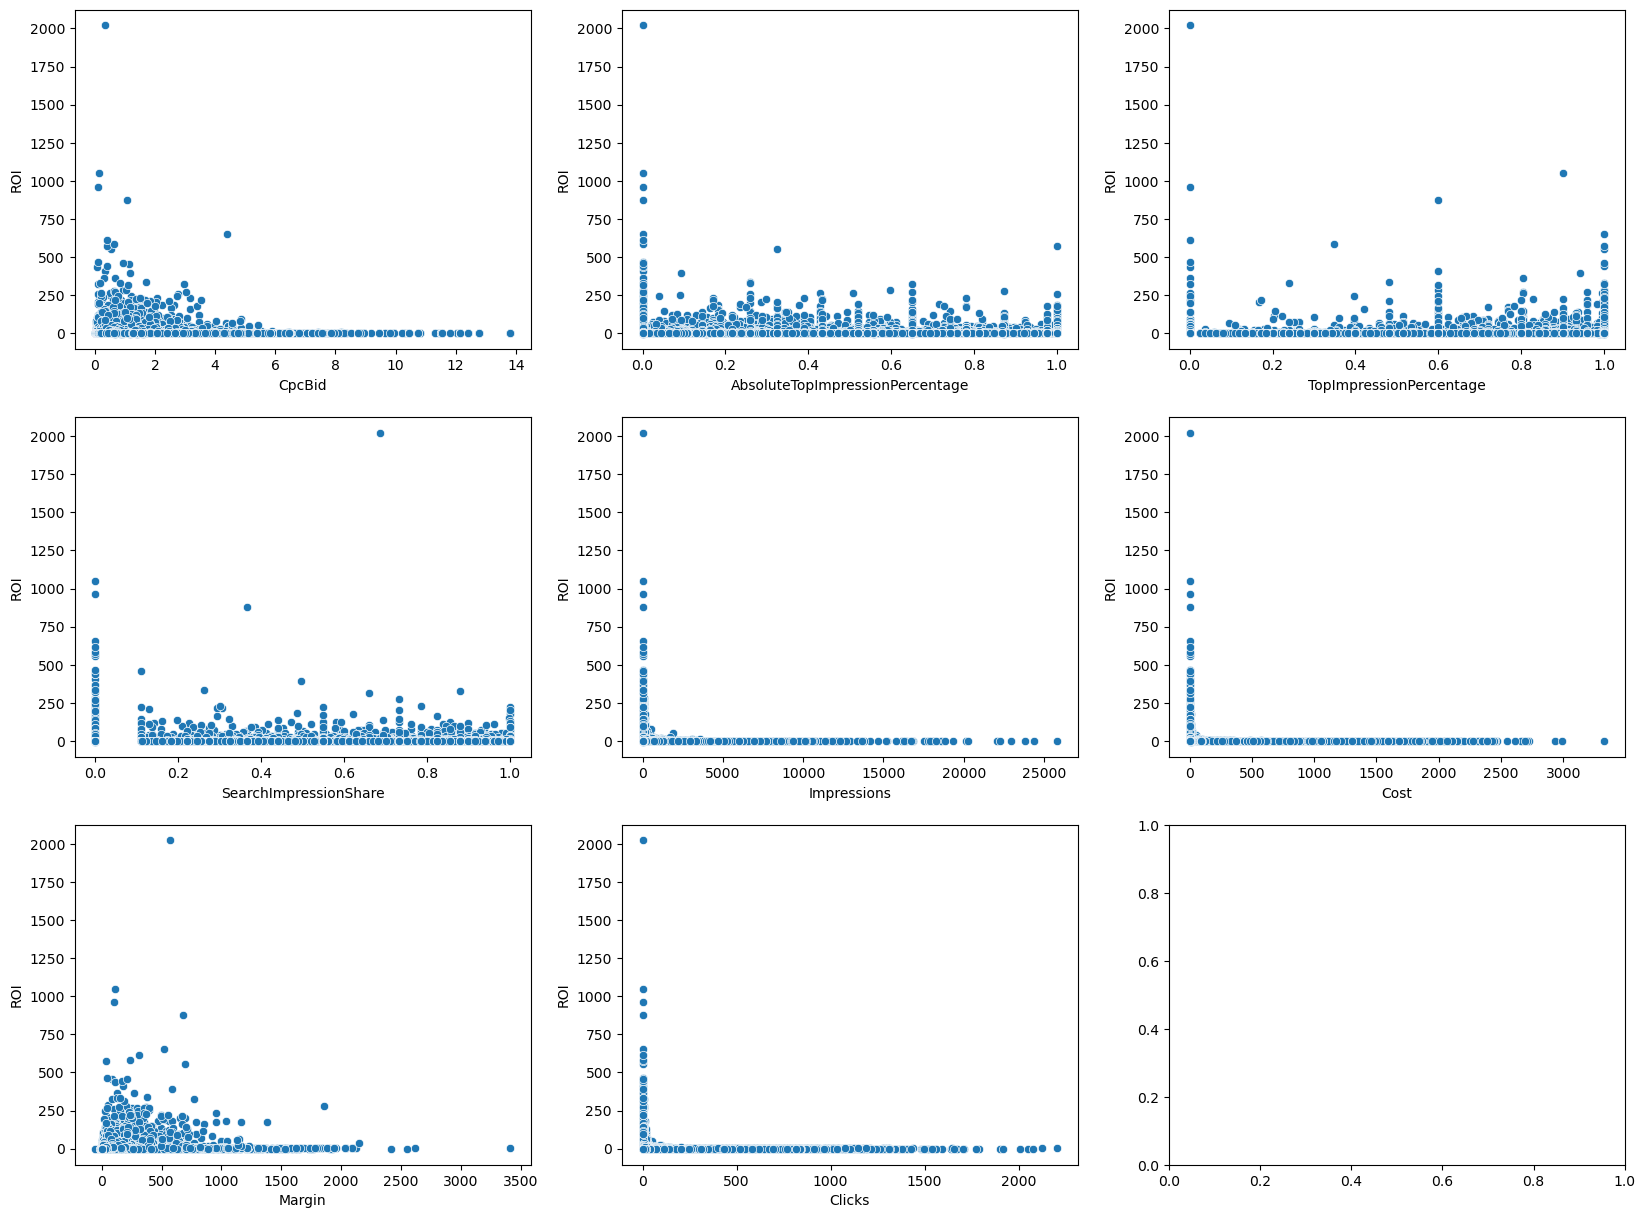

In [8]:
# Linear Relationships - ROI 
fig, ax = plt.subplots(3, 3, figsize=(20, 15))  # adjusted to a 3x3 grid
sns.scatterplot(x=df['CpcBid'], y=df['ROI'], ax=ax[0, 0])
sns.scatterplot(x=df['AbsoluteTopImpressionPercentage'], y=df['ROI'], ax=ax[0, 1])
sns.scatterplot(x=df['TopImpressionPercentage'], y=df['ROI'], ax=ax[0, 2])
sns.scatterplot(x=df['SearchImpressionShare'], y=df['ROI'], ax=ax[1, 0])
sns.scatterplot(x=df['Impressions'], y=df['ROI'], ax=ax[1, 1])
sns.scatterplot(x=df['Cost'], y=df['ROI'], ax=ax[1, 2])
sns.scatterplot(x=df['Margin'], y=df['ROI'], ax=ax[2, 0])
sns.scatterplot(x=df['Clicks'], y=df['ROI'], ax=ax[2, 1])

plt.show()

### Correlation between features

In [9]:
# Correlation between features
corr = df.corr(numeric_only=True)
corr_unstacked = corr.unstack()
corr_unstacked_sorted = corr_unstacked.sort_values(kind='quicksort', ascending=False)
corr_df = pd.Series.to_frame(corr_unstacked_sorted, name='correlation')
corr_df = corr_df.drop_duplicates()  # Remove duplicate rows
high_corr_features = corr_df[corr_df.correlation != 1]  # remove self correlation
high_corr_features.head(15)

correlation
Clicks                          Cost                                0.930310
Impressions                     Clicks                              0.898083
                                Cost                                0.832260
Clicks                          Margin                              0.707196
Margin                          Cost                                0.693713
TopImpressionPercentage         AbsoluteTopImpressionPercentage     0.672677
Margin                          Impressions                         0.583893
SearchImpressionShare           TopImpressionPercentage             0.335858
ROI                             Margin                              0.236581
SearchImpressionShare           AbsoluteTopImpressionPercentage     0.184696
CpcBid                          AbsoluteTopImpressionPercentage     0.180524
Impressions                     TopImpressionPercentage             0.150016
TopImpressionPercentage         AdGroupId                           0.141922
CpcBid                          SearchImpressionShare               0.134790
AbsoluteTopImpressionPercentage Cost                                0.134674

#### Sanity Checks

Clicks v Cost: The more clicks the more it cost as you pay for clicks

Impressions v Clicks: The more impressions the more clicks as the ad is exposed more

Cost v Impressions: It cost to have more impressions 

Margin v Clicks: Bookings are more likely if people click 

Margin v Cost: More booking due to more clicks and impressions

TopImpressionPercentage v AbsoluteTopImpressionPercentage: Trivial (?)

Impression v Margin: More exposure more likely for bookings

SearchImpressionShare v TopImpressionPercentage: Trivial (?)

ROI v Margin: Higher returns when there are more bookings

## Data Analysis and Visualisation

###  Keyword ROI Stats

In [10]:
# Group by KeywordId and calculate the mean, max, and min ROI values
keyword_stats = df.groupby('KeywordId')['ROI'].agg(['mean', 'max', 'min'])

# Rename the columns
keyword_stats = keyword_stats.rename(columns={'mean': 'Mean ROI', 'max': 'Max ROI', 'min': 'Min ROI'})

# Print the keyword statistics
keyword_stats

,Mean ROI,Max ROI,Min ROI
KeywordId,,,
100112314393,0.000000,0.000000,0.0
100607191,0.074091,12.011081,0.0
100607471,0.163868,16.442058,0.0
100852940,0.043741,10.145409,0.0
100858064,0.105478,5.244934,0.0
...,...,...,...
99355104,0.365279,28.986456,0.0
99358224,0.686554,51.918452,0.0
99586660,0.017310,2.363615,0.0


In [11]:
# How many KeywordIDs have never resulted in a positive ROI

# Group by KeywordId and calculate the max ROI values
keyword_max = df.groupby('KeywordId')['ROI'].max()

# Count the number of keywords with zero and non-zero max ROI
zero_max_count = (keyword_max <= 0).sum()
nonzero_max_count = (keyword_max > 0).sum()

# Print the counts
print("Number of keywords with zero max ROI:", zero_max_count)
print("Number of keywords with non-zero max ROI:", nonzero_max_count)

Number of keywords with zero max ROI: 930
Number of keywords with non-zero max ROI: 3461


In [ ]:
# How many achieved the target yesterday
# Find the latest date in the dataset
latest_date = df['Date'].max()

# Calculate the date a week before the latest date
week_before_latest_date = latest_date - pd.to_timedelta(7, unit='d')

# For the latest date
filtered_df_latest = df[(df['Date'] == latest_date) & (df['ROI'] >= 2)]
unique_keyword_ids_latest = filtered_df_latest['KeywordId'].nunique()

# For the past week
filtered_df_week = df[(df['Date'] >= week_before_latest_date) & (df['Date'] <= latest_date) & (df['ROI'] >= 2)]
unique_keyword_ids_week = filtered_df_week['KeywordId'].nunique()

# All time
filtered_df_all = df[df['ROI'] >= 2]
unique_keyword_ids_all = filtered_df_all['KeywordId'].nunique()

# Count total unique KeywordIds
total_unique_keyword_ids = df['KeywordId'].nunique()

# Calculate percentages
percentage_latest = (unique_keyword_ids_latest / total_unique_keyword_ids) * 100
percentage_week = (unique_keyword_ids_week / total_unique_keyword_ids) * 100
percentage_all = (unique_keyword_ids_all / total_unique_keyword_ids) * 100

# Print results
print(f"Latest date: {unique_keyword_ids_latest} unique KeywordIds ({percentage_latest}% of total)")
print(f"Past week: {unique_keyword_ids_week} unique KeywordIds ({percentage_week}% of total)")
print(f"All time: {unique_keyword_ids_all} unique KeywordIds ({percentage_all}% of total)")

# Filter DataFrame where 'ROI' achieved the target
filtered_df_all = df[df['ROI'] >= 2]

# Group by 'Date' and count unique 'KeywordId'
grouped_df = filtered_df_all.groupby('Date')['KeywordId'].nunique()

# Plot the data
plt.figure(figsize=(10,6))
grouped_df.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of Unique KeywordId')
plt.title('Number of Unique KeywordId that Achieved the Target ROI Over Time')
plt.show()

### Average ROI of all KeywordIds

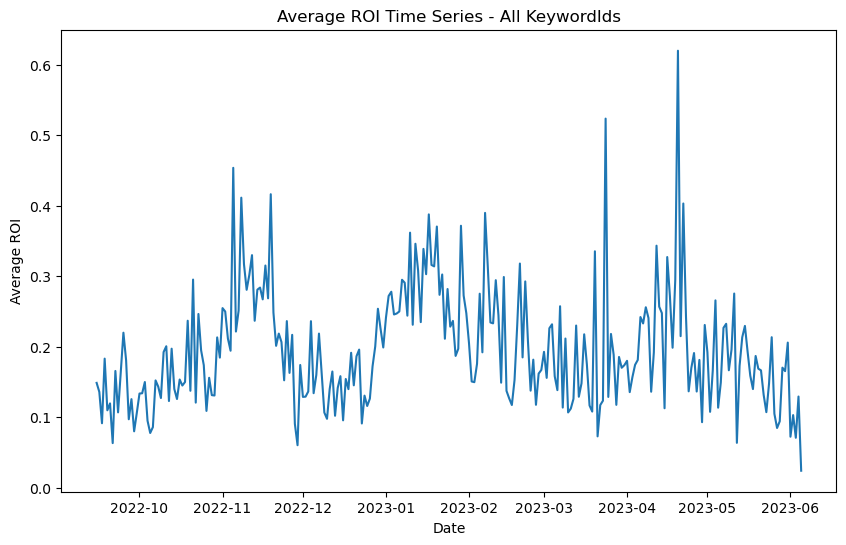

In [12]:
# Calculate the average ROI across all KeywordIds for each date
average_roi_by_date = df.groupby('Date')['ROI'].mean()

# Plot the average ROI time series
plt.figure(figsize=(10, 6))
plt.plot(average_roi_by_date.index, average_roi_by_date.values)
plt.title('Average ROI Time Series - All KeywordIds')
plt.xlabel('Date')
plt.ylabel('Average ROI')
plt.show()

### Average Bid for all KeywordIds

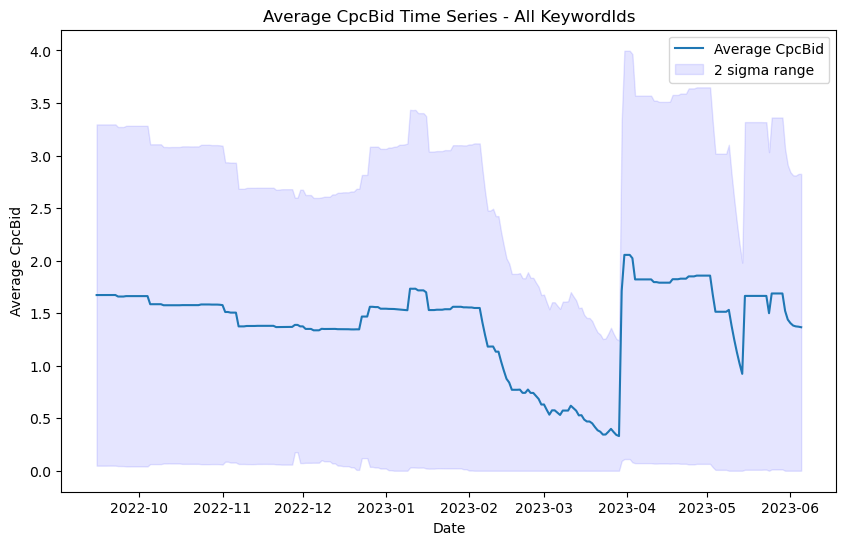

In [13]:
# Calculate the average and standard deviation of CpcBid across all KeywordIds for each date
average_cpcbid_by_date = df.groupby('Date')['CpcBid'].mean()
std_cpcbid_by_date = df.groupby('Date')['CpcBid'].std()

# Calculate the upper and lower bounds for the 2 sigma error band
upper_bound = average_cpcbid_by_date + 2*std_cpcbid_by_date
lower_bound = average_cpcbid_by_date - 2*std_cpcbid_by_date

# Ensure the lower band is not less than zero
lower_bound = lower_bound.clip(lower=0)

# Plot the average CpcBid time series along with the 2 sigma error band
plt.figure(figsize=(10, 6))
plt.plot(average_cpcbid_by_date.index, average_cpcbid_by_date.values, label='Average CpcBid')
plt.fill_between(average_cpcbid_by_date.index, lower_bound, upper_bound, color='b', alpha=.1, label='2 sigma range')
plt.title('Average CpcBid Time Series - All KeywordIds')
plt.xlabel('Date')
plt.ylabel('Average CpcBid')
plt.legend()
plt.show()


### Sum Clicks of all KeywordIds

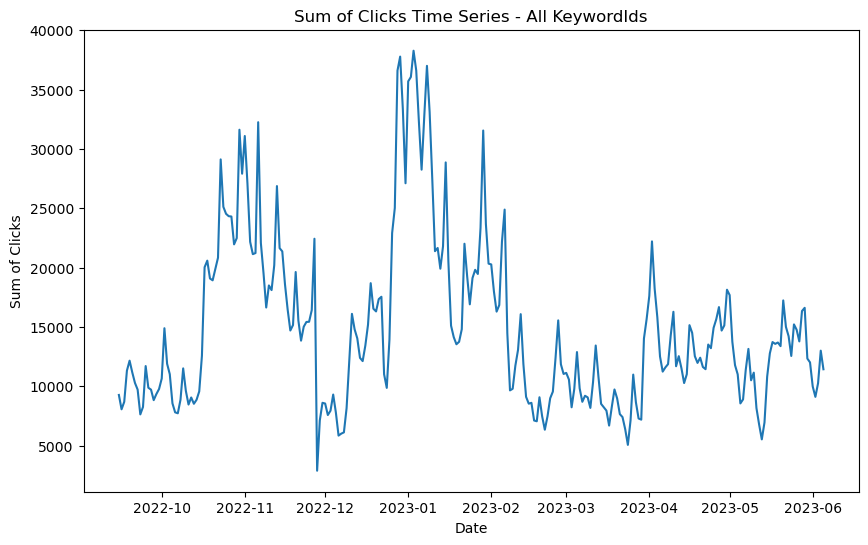

In [14]:
# Calculate the sum of Clicks across all KeywordIds for each date
sum_clicks_by_date = df.groupby('Date')['Clicks'].sum()

# Plot the sum of Clicks time series
plt.figure(figsize=(10, 6))
plt.plot(sum_clicks_by_date.index, sum_clicks_by_date.values)
plt.title('Sum of Clicks Time Series - All KeywordIds')
plt.xlabel('Date')
plt.ylabel('Sum of Clicks')
plt.show()


### Metrics timeseries plot for top clicked keyword

In [15]:
# Define the range of top KeywordIds to plot 
start_index = 0  # Starting index (inclusive)
end_index = 1  # Ending index (exclusive)

metrics = ['CpcBid', 'Clicks', 'Margin', 'Cost']


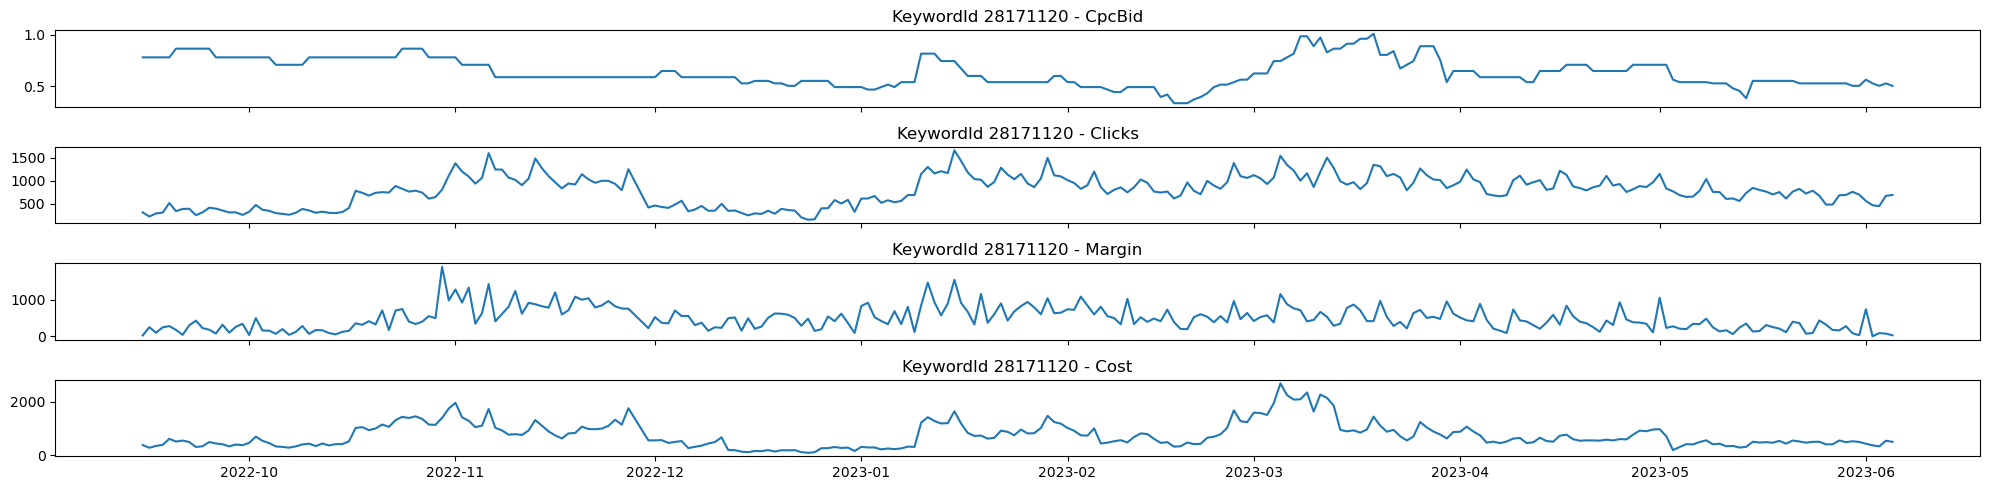

In [16]:
# Filter the DataFrame to include only the specified range of KeywordIds based on total Clicks
top_keywords_range = df.groupby('KeywordId')['Clicks'].sum().nlargest(end_index)
top_keywords = top_keywords_range.iloc[start_index:end_index].index
top_df = df[df['KeywordId'].isin(top_keywords)]

# Check if there are multiple keywords
if len(top_keywords) > 1:
    fig, axs = plt.subplots(len(top_keywords), len(metrics), figsize=(5*len(metrics), 5*len(top_keywords)), sharex=True)
    # For each keyword, plot each metric in a separate subplot
    for i, keyword_id in enumerate(top_keywords):
        for j, metric in enumerate(metrics):
            data = top_df[top_df['KeywordId'] == keyword_id]
            axs[i, j].plot(data['Date'], data[metric])
            axs[i, j].set_title(f'KeywordId {keyword_id} - {metric}')
else:
    fig, axs = plt.subplots(len(metrics), figsize=(5*len(metrics), 5), sharex=True)
    # For each metric, plot in a separate subplot
    for i, metric in enumerate(metrics):
        data = top_df[top_df['KeywordId'] == top_keywords[0]]
        axs[i].plot(data['Date'], data[metric])
        axs[i].set_title(f'KeywordId {top_keywords[0]} - {metric}')

plt.tight_layout()
plt.show()


### Timeseries Clicks - Range of top clicked KeywordIDs and Average

In [17]:
# Define the range of top KeywordIds to plot 
start_index = 0  # Starting index (inclusive)
end_index = 10  # Ending index (exclusive)

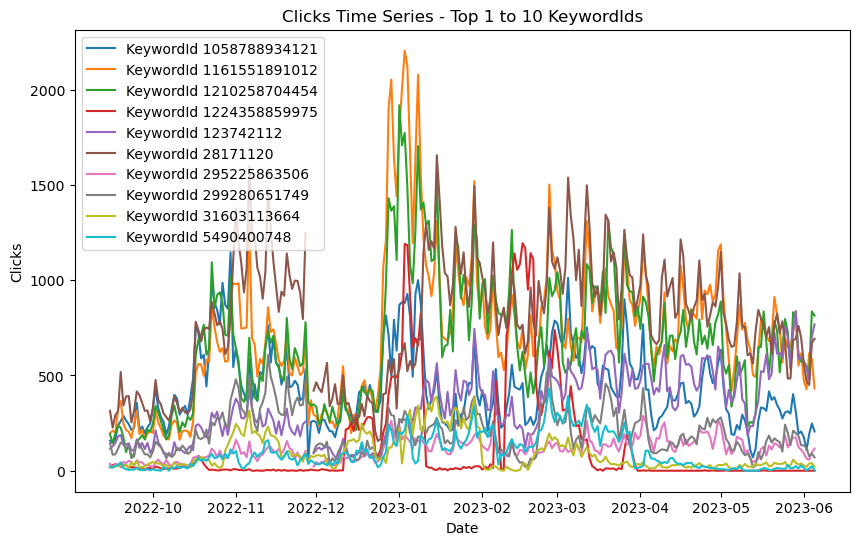

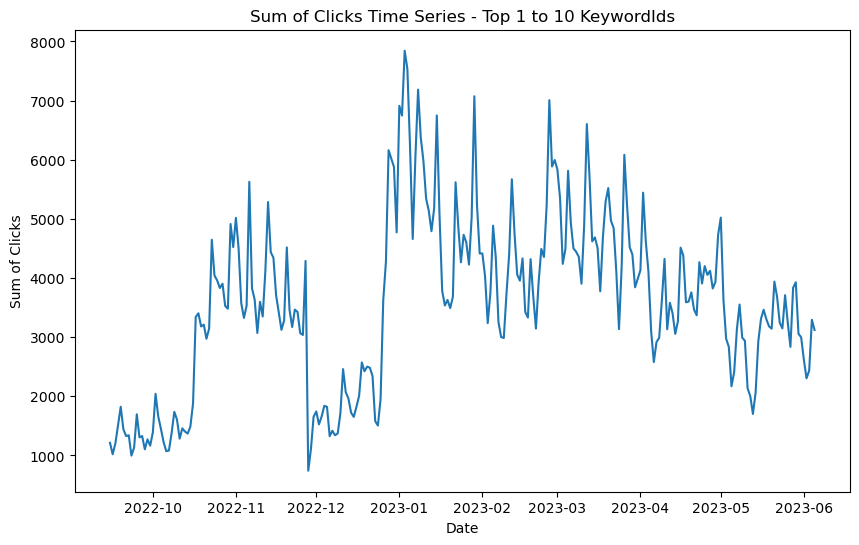

In [18]:

# Filter the DataFrame to include only the specified range of KeywordIds based on total Clicks
top_keywords_range = df.groupby('KeywordId')['Clicks'].sum().nlargest(end_index)
top_keywords = top_keywords_range.iloc[start_index:end_index].index
top_df = df[df['KeywordId'].isin(top_keywords)]

# Group by 'Date' and 'KeywordId' and calculate the sum of Clicks for each date and keyword
clicks_by_date_keyword = top_df.groupby(['Date', 'KeywordId'])['Clicks'].sum()

# Plot the time series of Clicks for each KeywordId
plt.figure(figsize=(10, 6))
for keyword_id, clicks in clicks_by_date_keyword.unstack().items():
    plt.plot(clicks.index, clicks.values, label=f'KeywordId {keyword_id}')
plt.title(f'Clicks Time Series - Top {start_index + 1} to {end_index} KeywordIds')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.legend()
plt.show()

# Calculate the average Clicks across all top KeywordIds in the specified range for each date
average_clicks_by_date = top_df.groupby('Date')['Clicks'].sum()

# Plot the sum Clicks time series
plt.figure(figsize=(10, 6))
plt.plot(average_clicks_by_date.index, average_clicks_by_date.values)
plt.title(f'Sum of Clicks Time Series - Top {start_index + 1} to {end_index} KeywordIds')
plt.xlabel('Date')
plt.ylabel('Sum of Clicks')
plt.show()

###  Timeseries ROI - Range of top clicked KeywordIDs and Average

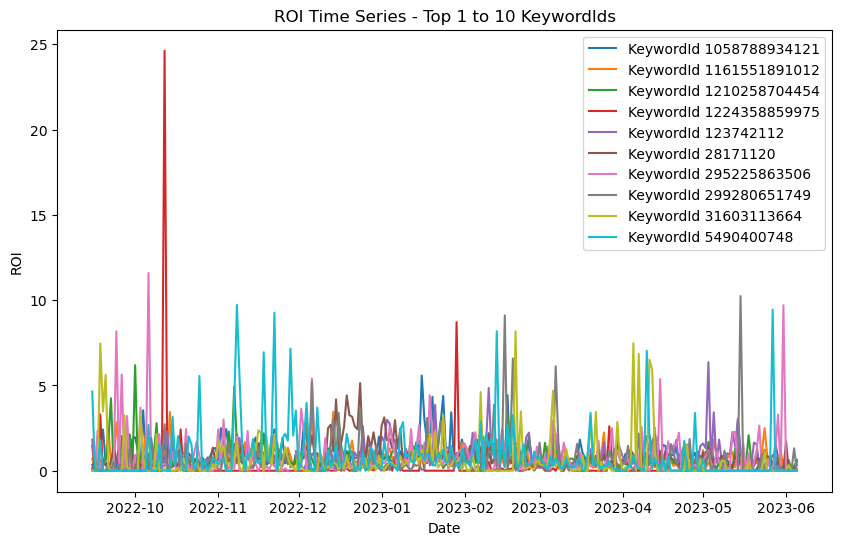

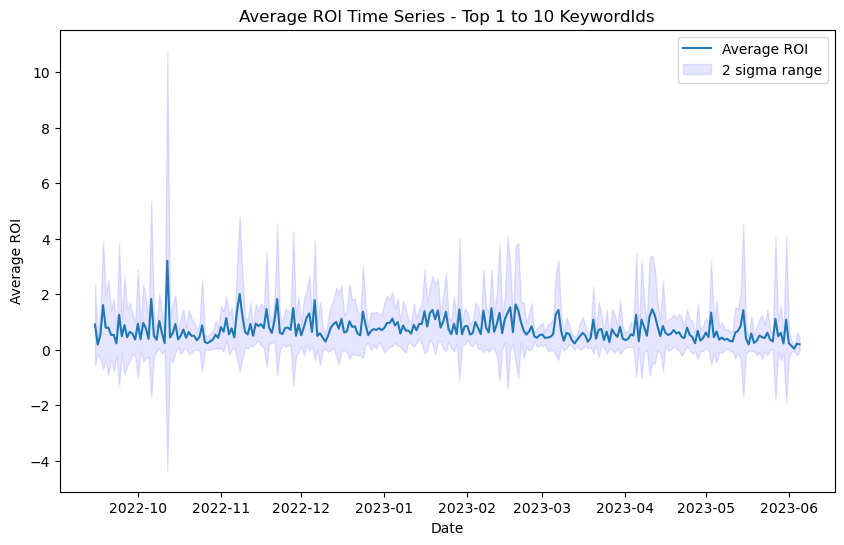

In [19]:
# Group by 'Date' and 'KeywordId' and calculate the sum of ROI for each date and keyword
roi_by_date_keyword = top_df.groupby(['Date', 'KeywordId'])['ROI'].mean()

# Plot the time series of ROI for each KeywordId
plt.figure(figsize=(10, 6))
for keyword_id, roi in roi_by_date_keyword.unstack().items():
    plt.plot(roi.index, roi.values, label=f'KeywordId {keyword_id}')
plt.title(f'ROI Time Series - Top {start_index + 1} to {end_index} KeywordIds')
plt.xlabel('Date')
plt.ylabel('ROI')
plt.legend()
plt.show()

# Calculate the average and standard deviation of ROI across all top KeywordIds in the specified range for each date
average_roi_by_date = top_df.groupby('Date')['ROI'].mean()
std_roi_by_date = top_df.groupby('Date')['ROI'].std()

# Calculate the upper and lower bounds for the 2 sigma error band
upper_bound = average_roi_by_date + 1*std_roi_by_date
lower_bound = average_roi_by_date - 1*std_roi_by_date

# Plot the average ROI time series along with the 2 sigma error band
plt.figure(figsize=(10, 6))
plt.plot(average_roi_by_date.index, average_roi_by_date.values, label='Average ROI')
plt.fill_between(average_roi_by_date.index, lower_bound, upper_bound, color='b', alpha=.1, label='2 sigma range')
plt.title(f'Average ROI Time Series - Top {start_index + 1} to {end_index} KeywordIds')
plt.xlabel('Date')
plt.ylabel('Average ROI')
plt.legend()
plt.show()


## Feature Engineering
### Days until next UK holiday and payday

In [20]:
# Convert 'Date' to datetime and extract relevant features
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Get UK holidays in the range of years in your dataset
uk_holidays = holidays.UK(years=list(range(df['Date'].dt.year.min(), df['Date'].dt.year.max() + 1)))

# Function to calculate days until next holiday
def days_until_next_holiday(row_date):
    date = row_date.date()  # convert Timestamp to datetime.date
    future_holidays = [d for d in uk_holidays.keys() if d > date]
    if future_holidays:  # check if there is any future holiday
        next_holiday = min(future_holidays)
        return (next_holiday - date).days
    else:
        return np.nan

# Apply the function to 'Date' column to create 'DaysUntilNextHoliday' feature
df['DaysUntilNextHoliday'] = df['Date'].apply(days_until_next_holiday)

# Function to calculate days until next payday
def days_until_next_payday(row_date):
    # Last business day of the month
    last_business_day = row_date + BMonthEnd(1)
    return (last_business_day - row_date).days

# Apply the function to 'Date' column to create 'DaysUntilNextPayday' feature
df['DaysUntilNextPayday'] = df['Date'].apply(days_until_next_payday)

# Print head
df.head()

,AdGroupId,KeywordId,Keyword,Date,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,Impressions,Clicks,Cost,Margin,ROI,Month,DayOfWeek,DaysUntilNextHoliday,DaysUntilNextPayday
0,143665864253,301448549744,hen weekends abroad,2022-09-15,2.292,0.000,0.000,0.0,0,0,0.00000,0.0,0.0,9,3,4,15
1,146372247960,1713432234206,holidays2024,2022-09-15,0.768,0.000,0.000,0.0,0,0,0.00000,0.0,0.0,9,3,4,15
2,143665839733,364851922036,+beach +luxury +holidays,2022-09-15,3.348,0.520,0.960,0.0,38,0,0.00000,0.0,0.0,9,3,4,15
3,146372231240,306355270770,+august +vacations,2022-09-15,3.600,0.754,0.996,0.0,44,2,0.00000,0.0,0.0,9,3,4,15
4,146372229320,19131834622,warm holidays in october,2022-09-15,3.756,0.780,1.000,0.0,56,4,6.79836,0.0,0.0,9,3,4,15


### Rolling Average for 'after the fact' data

In [21]:
#Time
df = df.sort_values('Date', ascending=True)

# Define the metrics for which you want to calculate the rolling average
metrics = ['AbsoluteTopImpressionPercentage', 'TopImpressionPercentage', 'SearchImpressionShare', 'Impressions','Margin','ROI']

# Define the window size for the rolling average (days)
window_size = 7  # Note the initial data is lost as we have NanB

# Calculate the rolling average for each metric
for metric in metrics:
    rolling_avg = df[metric].rolling(window_size).mean()
    df[f'{metric}_RollingAvg'] = rolling_avg

# Remove rows with NaN values
df.dropna(inplace=True)

# Print the updated DataFrame
df.head()


,AdGroupId,KeywordId,Keyword,Date,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,Impressions,Clicks,...,Month,DayOfWeek,DaysUntilNextHoliday,DaysUntilNextPayday,AbsoluteTopImpressionPercentage_RollingAvg,TopImpressionPercentage_RollingAvg,SearchImpressionShare_RollingAvg,Impressions_RollingAvg,Margin_RollingAvg,ROI_RollingAvg
2854,142284480405,11457669278,february half term holiday deals,2022-09-15,1.044,0.650,1.0,0.0,8,0,...,9,3,4,15,0.302571,0.428571,0.0,22.857143,0.000000,0.000000
2855,146372227840,2430147244,best christmas holidays,2022-09-15,3.768,0.936,1.0,0.0,248,18,...,9,3,4,15,0.436286,0.571429,0.0,58.285714,0.969459,0.064258
2856,143665847493,297024911494,+last +minute +hotel,2022-09-15,1.620,0.169,1.0,0.0,42,4,...,9,3,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258
2857,142284487085,20794808471,+short +easter +breaks,2022-09-15,0.792,0.000,0.0,0.0,0,0,...,9,3,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258
2858,142284479005,4165969607,cheap may holidays,2022-09-15,0.624,0.000,0.0,0.0,0,0,...,9,3,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258


### Broad search Classifier

In [22]:
#Keywords with + suggest broad search 

# Create a new column 'BroadSearch' with default value False
df['BroadSearch'] = False

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    keyword = row['Keyword']
    # Check if the keyword contains a plus sign (+)
    if '+' in keyword:
        df.at[index, 'BroadSearch'] = True

df.head()

,AdGroupId,KeywordId,Keyword,Date,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,Impressions,Clicks,...,DayOfWeek,DaysUntilNextHoliday,DaysUntilNextPayday,AbsoluteTopImpressionPercentage_RollingAvg,TopImpressionPercentage_RollingAvg,SearchImpressionShare_RollingAvg,Impressions_RollingAvg,Margin_RollingAvg,ROI_RollingAvg,BroadSearch
2854,142284480405,11457669278,february half term holiday deals,2022-09-15,1.044,0.650,1.0,0.0,8,0,...,3,4,15,0.302571,0.428571,0.0,22.857143,0.000000,0.000000,False
2855,146372227840,2430147244,best christmas holidays,2022-09-15,3.768,0.936,1.0,0.0,248,18,...,3,4,15,0.436286,0.571429,0.0,58.285714,0.969459,0.064258,False
2856,143665847493,297024911494,+last +minute +hotel,2022-09-15,1.620,0.169,1.0,0.0,42,4,...,3,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258,True
2857,142284487085,20794808471,+short +easter +breaks,2022-09-15,0.792,0.000,0.0,0.0,0,0,...,3,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258,True
2858,142284479005,4165969607,cheap may holidays,2022-09-15,0.624,0.000,0.0,0.0,0,0,...,3,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258,False


### ROI Classifier

In [23]:
# Target Variable has it achieved ROI Target
df['ROI_target'] = df['ROI'] >= 2

df.head()

,AdGroupId,KeywordId,Keyword,Date,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,Impressions,Clicks,...,DaysUntilNextHoliday,DaysUntilNextPayday,AbsoluteTopImpressionPercentage_RollingAvg,TopImpressionPercentage_RollingAvg,SearchImpressionShare_RollingAvg,Impressions_RollingAvg,Margin_RollingAvg,ROI_RollingAvg,BroadSearch,ROI_target
2854,142284480405,11457669278,february half term holiday deals,2022-09-15,1.044,0.650,1.0,0.0,8,0,...,4,15,0.302571,0.428571,0.0,22.857143,0.000000,0.000000,False,False
2855,146372227840,2430147244,best christmas holidays,2022-09-15,3.768,0.936,1.0,0.0,248,18,...,4,15,0.436286,0.571429,0.0,58.285714,0.969459,0.064258,False,False
2856,143665847493,297024911494,+last +minute +hotel,2022-09-15,1.620,0.169,1.0,0.0,42,4,...,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258,True,False
2857,142284487085,20794808471,+short +easter +breaks,2022-09-15,0.792,0.000,0.0,0.0,0,0,...,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258,True,False
2858,142284479005,4165969607,cheap may holidays,2022-09-15,0.624,0.000,0.0,0.0,0,0,...,4,15,0.393571,0.571429,0.0,43.142857,0.969459,0.064258,False,False


In [24]:
# Instances where ROI target has been achieved 
df['ROI_target'].value_counts()

# unbalanced dataset

False    1133461
True       15477
Name: ROI_target, dtype: int64

In [25]:
#How many times has ROI achieved this before per keywordID

# Save original index in a temporary column
df['temp_index'] = df.index

# Sort the dataframe
df.sort_values(['KeywordId', 'Date'], inplace=True)

# Add the 'Count_Achieved_ROI' column
df['Count_Achieved_ROI'] = 0
for key, grp in df.groupby('KeywordId'):
    df.loc[grp.index, 'Count_Achieved_ROI'] = (grp['ROI'].shift(1).expanding().apply(lambda x: (x>=2).sum()))

# Re-sort the dataframe based on the original order
df.sort_values('temp_index', inplace=True)

# Delete the temporary index column
df.drop('temp_index', axis=1, inplace=True)

# Fill NaN values with 0
df['Count_Achieved_ROI'] = df['Count_Achieved_ROI'].fillna(0)

df.head()


,AdGroupId,KeywordId,Keyword,Date,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,Impressions,Clicks,...,DaysUntilNextPayday,AbsoluteTopImpressionPercentage_RollingAvg,TopImpressionPercentage_RollingAvg,SearchImpressionShare_RollingAvg,Impressions_RollingAvg,Margin_RollingAvg,ROI_RollingAvg,BroadSearch,ROI_target,Count_Achieved_ROI
1,146372247960,1713432234206,holidays2024,2022-09-15,0.768,0.000,0.000,0.0,0,0,...,15,0.074286,0.166286,0.0,11.428571,0.0,0.0,False,False,0.0
2,143665839733,364851922036,+beach +luxury +holidays,2022-09-15,3.348,0.520,0.960,0.0,38,0,...,15,0.148571,0.303429,0.0,16.857143,0.0,0.0,True,False,0.0
3,146372231240,306355270770,+august +vacations,2022-09-15,3.600,0.754,0.996,0.0,44,2,...,15,0.182000,0.308571,0.0,17.142857,0.0,0.0,True,False,0.0
4,146372229320,19131834622,warm holidays in october,2022-09-15,3.756,0.780,1.000,0.0,56,4,...,15,0.293429,0.451429,0.0,25.142857,0.0,0.0,False,False,0.0
5,142284492205,417834244744,+resorts +december,2022-09-15,2.436,0.520,1.000,0.0,66,8,...,15,0.367714,0.565143,0.0,30.000000,0.0,0.0,True,False,0.0


## Data Preprocessing  

In [26]:
# Define features and targets
features_clicks = ['KeywordId', 'Month', 'DayOfWeek', 'CpcBid', 'DaysUntilNextHoliday', 'DaysUntilNextPayday',
                   'AbsoluteTopImpressionPercentage_RollingAvg', 'TopImpressionPercentage_RollingAvg',
                   'SearchImpressionShare_RollingAvg', 'Impressions_RollingAvg', 
                   'BroadSearch'
                  ]

#features_roi = ['KeywordId', 'Clicks', 'Month', 'DayOfWeek', 'CpcBid', 'DaysUntilNextHoliday','DaysUntilNextPayday', 
 #           'AbsoluteTopImpressionPercentage_RollingAvg','TopImpressionPercentage_RollingAvg',
  #          'SearchImpressionShare_RollingAvg', 'Impressions_RollingAvg', 'Margin_RollingAvg']

features_roi = ['KeywordId', 'Clicks', 'Month', 'DayOfWeek', 'CpcBid', 'DaysUntilNextHoliday','DaysUntilNextPayday', 
             #'Margin_RollingAvg', 
               'Count_Achieved_ROI', 'ROI_RollingAvg'
               ]

# For plots
features_roi_plot = ['KeywordId', 'Clicks', 'Month', 'DayOfWeek', 'CpcBid', 'DaysUntilNextHoliday','DaysUntilNextPayday', 
             #'Margin_RollingAvg', 
               'Count_Achieved_ROI', 'ROI_RollingAvg', 'Date'
               ]

features_clicks_plot = ['KeywordId', 'Month', 'DayOfWeek', 'CpcBid', 'DaysUntilNextHoliday', 'DaysUntilNextPayday',
                   'AbsoluteTopImpressionPercentage_RollingAvg', 'TopImpressionPercentage_RollingAvg',
                   'SearchImpressionShare_RollingAvg', 'Impressions_RollingAvg', 
                   'BroadSearch', 'Date'
                  ]



# Specify that 'KeywordId' is a categorical feature
cat_features = ['KeywordId']

# Splitting data
X_roi = df[features_roi]
X_clicks = df[features_clicks]
X_clicks_plot = df[features_clicks_plot]
X_roi_plot = df[features_roi_plot]


y_roi_class = df['ROI_target']
y_roi = df['ROI']
y_clicks = df['Clicks']

### Data Scalling
tree-based models like CatBoost, Random Forest, and Gradient Boosting do not require feature scaling

### Timeseries data split

In [27]:
# Define split fractions
train_frac = 0.75
val_frac = 0.15
test_frac = 0.10

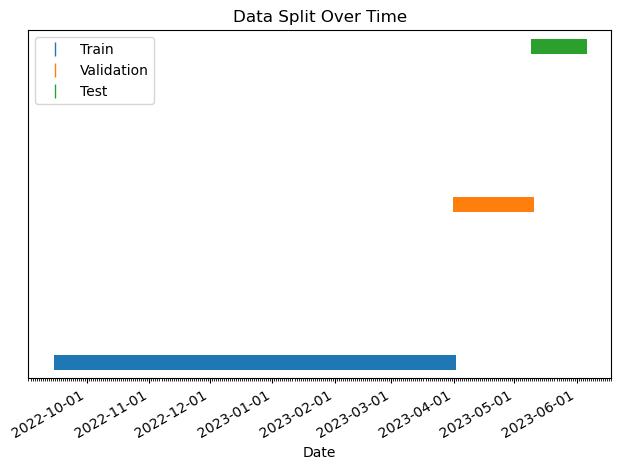

Train data: start date 2022-09-15 00:00:00, end date 2023-04-01 00:00:00, duration 198 days
Validation data: start date 2023-04-01 00:00:00, end date 2023-05-10 00:00:00, duration 39 days
Test data: start date 2023-05-10 00:00:00, end date 2023-06-05 00:00:00, duration 26 days


In [28]:
# Perform time-based splitting
df = df.sort_values('Date', ascending=True)

train_size = int(len(df) * train_frac)
val_size = int(len(df) * val_frac)
test_size = int(len(df) * test_frac)

X_train_roi, X_val_roi, X_test_roi = np.split(X_roi, [train_size, train_size+val_size])
X_train_clicks, X_val_clicks, X_test_clicks = np.split(X_clicks, [train_size, train_size+val_size])

X_train_roi_plot, X_val_roi_plot, X_test_roi_plot = np.split(X_roi_plot, [train_size, train_size+val_size])
X_train_clicks_plot, X_val_clicks_plot, X_test_clicks_plot = np.split(X_clicks_plot, [train_size, train_size+val_size])


y_train_roi, y_val_roi, y_test_roi = np.split(y_roi, [train_size, train_size+val_size])
y_train_roi_class, y_val_roi_class, y_test_roi_class = np.split(y_roi_class, [train_size, train_size+val_size])
y_train_clicks, y_val_clicks, y_test_clicks = np.split(y_clicks, [train_size, train_size+val_size])

# Create a new DataFrame for the plot
df_plot = df[['Date']].copy()
df_plot.loc[:train_size, 'Data Split'] = 'Train'
df_plot.loc[train_size:train_size+val_size, 'Data Split'] = 'Validation'
df_plot.loc[train_size+val_size:, 'Data Split'] = 'Test'

# Check sequential data split plot
fig, ax = plt.subplots()

# Add each category to the plot
for split in ['Train', 'Validation', 'Test']:
    ax.plot(df_plot[df_plot['Data Split'] == split]['Date'], 
            [split]*df_plot[df_plot['Data Split'] == split].shape[0], 
            marker='|', markersize=10, linestyle='', label=split)

# Format the x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()

# Other formatting and labels
plt.yticks([])
plt.xlabel('Date')
plt.title('Data Split Over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate the size of each split
train_size = int(len(df) * train_frac)
val_size = int(len(df) * val_frac)

# Extract the first and the last date of each split
train_start_date = df['Date'].iloc[0]
train_end_date = df['Date'].iloc[train_size - 1]

val_start_date = df['Date'].iloc[train_size]
val_end_date = df['Date'].iloc[train_size + val_size - 1]

test_start_date = df['Date'].iloc[train_size + val_size]
test_end_date = df['Date'].iloc[-1]

# Calculate the number of days in each split
train_days = (train_end_date - train_start_date).days
val_days = (val_end_date - val_start_date).days
test_days = (test_end_date - test_start_date).days

# Print results
print("Train data: start date {}, end date {}, duration {} days".format(train_start_date, train_end_date, train_days))
print("Validation data: start date {}, end date {}, duration {} days".format(val_start_date, val_end_date, val_days))
print("Test data: start date {}, end date {}, duration {} days".format(test_start_date, test_end_date, test_days))


# Click Model

### Model Selection and Training 


In [29]:
X_train_clicks.columns

Index(['KeywordId', 'Month', 'DayOfWeek', 'CpcBid', 'DaysUntilNextHoliday',
       'DaysUntilNextPayday', 'AbsoluteTopImpressionPercentage_RollingAvg',
       'TopImpressionPercentage_RollingAvg',
       'SearchImpressionShare_RollingAvg', 'Impressions_RollingAvg',
       'BroadSearch'],
      dtype='object')

In [ ]:

# Initialize CatBoostRegressor for Clicks
model_clicks = CatBoostRegressor(
                                  iterations=295, 
                                  depth = 4, 
                                  learning_rate = 0.5, 
                                  loss_function='RMSE',
                                  l2_leaf_reg = 8.8,
                                  random_seed=42
    
                                  )

# Fit Clicks model
model_clicks.fit(X_train_clicks, y_train_clicks, cat_features=cat_features)

### Save Model

In [30]:
# Save the trained model
#model_clicks.save_model('click_modelv1.cbm')

# Load the saved model
model_clicks = CatBoostRegressor()
model_clicks.load_model('click_modelv1.cbm')

###  Training Performance

Root Mean Squared Error (Clicks - Training): 6.828351633899185
R-squared (Clicks - Training): 0.9368138085842397


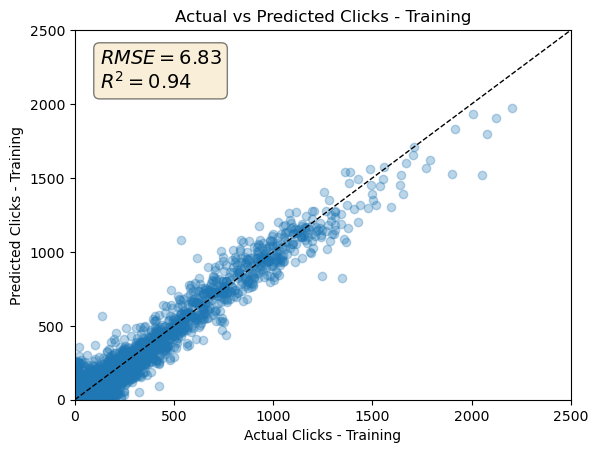

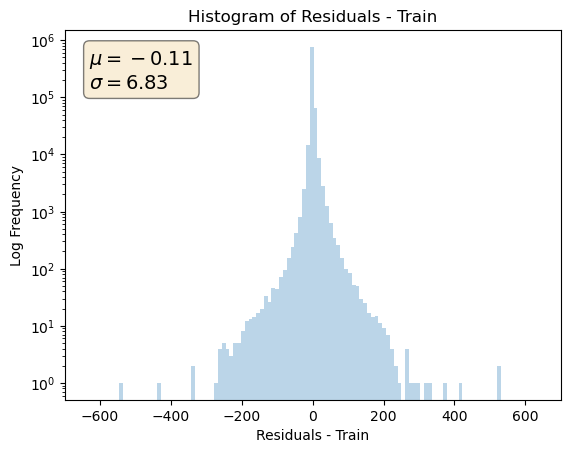

Mean of residuals: -0.11292524093537866
Standard deviation of residuals: 6.827417808070978


In [31]:
# Predict Clicks for training set
train_preds_clicks = model_clicks.predict(X_train_clicks)

# Replace negative predicted click values with zero
train_preds_clicks = np.where(train_preds_clicks < 0, 0, train_preds_clicks)

# Calculate RMSE for Clicks - Training
rmse_train_clicks = np.sqrt(mean_squared_error(y_train_clicks, train_preds_clicks))
print(f"Root Mean Squared Error (Clicks - Training): {rmse_train_clicks}")

# Calculate R2 for training set
r2_train_clicks = r2_score(y_train_clicks, train_preds_clicks)
print(f"R-squared (Clicks - Training): {r2_train_clicks}")

# Plot actual vs predicted Clicks for training set
plt.figure()
plt.scatter(y_train_clicks, train_preds_clicks, alpha=0.3)
plt.plot([0,2500], [0,2500], 'k--', lw=1)
plt.xlabel('Actual Clicks - Training')
plt.ylabel('Predicted Clicks - Training')
plt.title('Actual vs Predicted Clicks - Training')
plt.xlim(0, 2500)
plt.ylim(0, 2500)

# Add text box with RMSE and R2
textstr = '\n'.join((
    r'$RMSE=%.2f$' % (rmse_train_clicks, ),
    r'$R^2=%.2f$' % (r2_train_clicks, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Display plot
plt.show()

# Histogram of residuals
residuals_clicks_train = y_train_clicks - train_preds_clicks

# Calculate mean and standard deviation of residuals
mu_train = np.mean(residuals_clicks_train)
std_train = np.std(residuals_clicks_train)

# Create histogram
plt.figure()
plt.hist(residuals_clicks_train, bins=100, alpha=0.3, log=True)
plt.xlabel('Residuals - Train')
plt.ylabel('Log Frequency')
plt.title('Histogram of Residuals - Train')
plt.xlim(-700, 700)

# Add text box with mean and standard deviation
textstr_train = '\n'.join((
    r'$\mu=%.2f$' % (mu_train, ),
    r'$\sigma=%.2f$' % (std_train, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.05, 0.95, textstr_train, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Display plot
plt.show()

# Print results
print(f'Mean of residuals: {mu_train}')
print(f'Standard deviation of residuals: {std_train}')


###  Cross Validation Performance

R-squared (Clicks - Validation): 0.9110504027815292


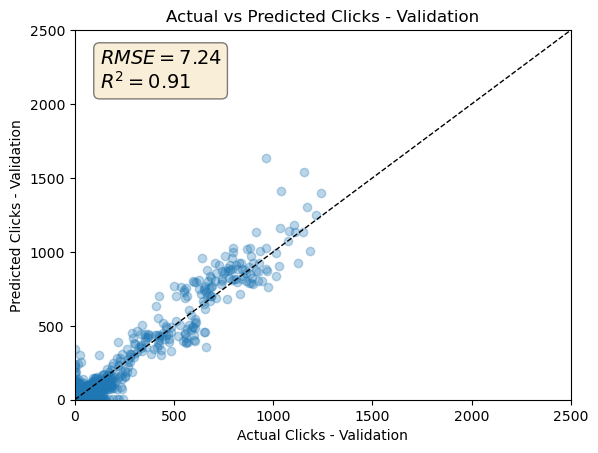

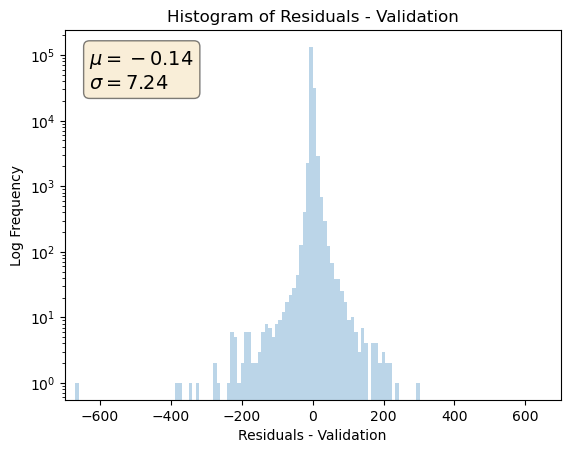

Mean of residuals: -0.14418402672006986
Standard deviation of residuals: 7.238560581053845


In [33]:




# Get predictions for cross-validation set
val_preds_clicks = model_clicks.predict(X_val_clicks)

# Replace negative predicted click values with zero
val_preds_clicks = np.where(val_preds_clicks < 0, 0, val_preds_clicks)

rmse_val_clicks = np.sqrt(mean_squared_error(y_val_clicks, val_preds_clicks))


# Calculate R2 for validation set
r2_val_clicks = r2_score(y_val_clicks, val_preds_clicks)
print(f"R-squared (Clicks - Validation): {r2_val_clicks}")



# Plot actual vs predicted Clicks for validation set
plt.figure()
plt.scatter(y_val_clicks, val_preds_clicks, alpha=0.3)
plt.plot([0,2500], [0,2500], 'k--', lw=1)
plt.xlabel('Actual Clicks - Validation')
plt.ylabel('Predicted Clicks - Validation')
plt.title('Actual vs Predicted Clicks - Validation')
plt.xlim(0, 2500)
plt.ylim(0, 2500)

# Add text box with RMSE and R2
textstr = '\n'.join((
    r'$RMSE=%.2f$' % (rmse_val_clicks, ),
    r'$R^2=%.2f$' % (r2_val_clicks, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Display plot
plt.show()

# Histogram of residuals
residuals_clicks_val = y_val_clicks - val_preds_clicks

# Calculate mean and standard deviation of residuals
mu = np.mean(residuals_clicks_val)
std = np.std(residuals_clicks_val)

# Create histogram
plt.figure()
plt.hist(residuals_clicks_val, bins=100, alpha=0.3, log=True)
plt.xlabel('Residuals - Validation')
plt.ylabel('Log Frequency')
plt.title('Histogram of Residuals - Validation')
plt.xlim(-700, 700)

# Add text box with mean and standard deviation
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (std, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Display plot
plt.show()

# Print results
print(f'Mean of residuals: {mu}')
print(f'Standard deviation of residuals: {std}')


In [34]:
# RMSE for training and cross-validation should be similiar <~10%
print(f"Root Mean Squared Error (Clicks - Training): {rmse_train_clicks}")
print(f"Root Mean Squared Error (Clicks - Validation): {rmse_val_clicks}")

difference = (rmse_val_clicks - rmse_train_clicks)/rmse_train_clicks *100
print(f"RMSE Difference (%): {difference}")

Root Mean Squared Error (Clicks - Training): 6.828351633899185
Root Mean Squared Error (Clicks - Validation): 7.239996430878976
RMSE Difference (%): 6.0284651267253135


### Hyperparameter Tuning 


- Experiment 1: Iterations: 1000, depth = 10 Learning rate = 0.9
  - RMSE Training: 3.81
  - RMSE Validation: 9.14
  - Appears to be overfitting
  - Decrease depth
- Experiment 2: Iterations: 1000, depth = 5 Learning rate = 0.9
  - RMSE Training: 5.18
  - RMSE Validation: 7.76
  - Better but still overfitting
  - Add l2_leaf_reg = 0.5
- Experiment 4: Iterations: 1000, depth = 5 Learning rate = 0.9, l2_leaf_reg = 0.5
  - RMSE Training: 5.34
  - RMSE Validation: 8.83
  - Worse
  - Search 
- Experiment 4: Iterations: 998, depth = 5 Learning rate = 0.77, l2_leaf_reg = 3.37
  - RMSE Training: 4.28
  - RMSE Validation: 7.28
  - Better
  - Early stopping?
- Experiment 5: Iterations: 200, depth = 5 Learning rate = 0.77, l2_leaf_reg = 3.37
  - RMSE Training: 6.52
  - RMSE Validation: 7.55
  - Even better
  - Check random seed 42    
- Experiment 6: Iterations: 300, depth = 4 Learning rate = 0.5, l2_leaf_reg = 8.8, random_seed= 42
  - RMSE Training: 7.02
  - RMSE Validation: 7.06
  - USE THIS MODEL click_model_tuned.cbm

In [ ]:
# Hyperparameter search to minimise training and cross validation RMSE 
# By optimizing the RMSE value for the validation set,
# you indirectly focus on minimizing the difference between the validation and training RMSE. 

class TqdmCallback:
    def __init__(self, total_trials):
        self.pbar = tqdm(total=total_trials)

    def __call__(self, study, trial):
        self.pbar.update()

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 10, 500),
        'depth': trial.suggest_int('depth', 3, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.5, 1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10),
        'random_seed': 42
    }

    model = CatBoostRegressor(loss_function='RMSE', **params)
    model.fit(X_train, y_train_clicks, cat_features=cat_features, verbose=False)

    train_preds_clicks = model.predict(X_train_clicks)
    train_preds_clicks = np.where(train_preds_clicks < 0, 0, train_preds_clicks)
    rmse_train_clicks = np.sqrt(mean_squared_error(y_train_clicks, train_preds_clicks))

    val_preds_clicks = model.predict(X_val_clicks)
    val_preds_clicks = np.where(val_preds_clicks < 0, 0, val_preds_clicks)
    rmse_val_clicks = np.sqrt(mean_squared_error(y_val_clicks, val_preds_clicks))

    rmse_difference = np.abs(rmse_train_clicks - rmse_val_clicks) / rmse_train_clicks * 100
    
    return rmse_difference

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, callbacks=[TqdmCallback(total_trials=10)])

best_params = study.best_params
best_model = CatBoostRegressor(loss_function='RMSE', **best_params)
best_model.fit(X_train, y_train_clicks, cat_features=cat_features)

train_preds_clicks = best_model.predict(X_train_clicks)
train_preds_clicks = np.where(train_preds_clicks < 0, 0, train_preds_clicks)
rmse_train_clicks = np.sqrt(mean_squared_error(y_train_clicks, train_preds_clicks))

val_preds_clicks = best_model.predict(X_val_clicks)
val_preds_clicks = np.where(val_preds_clicks < 0, 0, val_preds_clicks)
rmse_val_clicks = np.sqrt(mean_squared_error(y_val_clicks, val_preds_clicks))

difference = (rmse_val_clicks - rmse_train_clicks) / rmse_train_clicks * 100

print(f"Best Hyperparameters: {best_params}")
print(f"Root Mean Squared Error (Clicks - Training): {rmse_train_clicks}")
print(f"Root Mean Squared Error (Clicks - Validation): {rmse_val_clicks}")
print(f"RMSE Difference (%): {difference}")


# Save best model
best_model.save_model("best_click_model.cbm")





## Feature importance

In [35]:
# Get feature importance
feature_importance = model_clicks.get_feature_importance()

# Create a pandas dataframe to hold the feature names and their corresponding importance values
feature_importance_df = pd.DataFrame(list(zip(X_clicks.columns, feature_importance)), 
                                      columns=['Feature', 'Importance'])

# Sort the dataframe based on the feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the dataframe
feature_importance_df



,Feature,Importance
9,Impressions_RollingAvg,54.684060
0,KeywordId,37.572594
1,Month,2.695410
3,CpcBid,1.707190
4,DaysUntilNextHoliday,1.427293
7,TopImpressionPercentage_RollingAvg,0.567568
5,DaysUntilNextPayday,0.453409
6,AbsoluteTopImpressionPercentage_RollingAvg,0.353535
2,DayOfWeek,0.271674
10,BroadSearch,0.262266


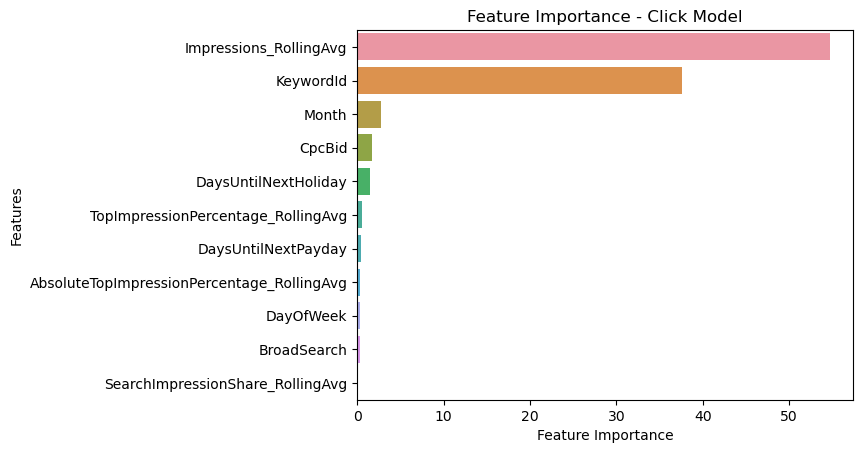

In [36]:
# Plot feature importance
plt.figure()
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Click Model')
plt.show()

## ROI Model Classification
Parameter has achieved an ROI of 2 or greater before (?)

In [37]:
X_train_roi.columns

Index(['KeywordId', 'Clicks', 'Month', 'DayOfWeek', 'CpcBid',
       'DaysUntilNextHoliday', 'DaysUntilNextPayday', 'Count_Achieved_ROI',
       'ROI_RollingAvg'],
      dtype='object')

### Unbalance dataset  (False) is 1133467 and the count of the positive class (True) is 15477.

#### The scale_pos_weight
parameter is used in algorithms such as XGBoost and CatBoost to help handle imbalanced datasets. It provides a way to give more importance to the minority class. The scale_pos_weight parameter can be set to the ratio of the number of negative class to the positive class. In your case, the count of the negative class (False) is 1133467 and the count of the positive class (True) is 15477.

#### Bagging 


In [38]:
scale_pos_weight = len(y_train_roi_class[y_train_roi_class==False]) / len(y_train_roi_class[y_train_roi_class==True])

In [ ]:
# Initialize CatBoostClassifier for ROI
model_roi_class = CatBoostClassifier(
    iterations=200,
    learning_rate=0.34059429878022707,
    depth=16,
    cat_features=cat_features,
    custom_loss=['Accuracy'],  # additional monitor
    eval_metric='Recall',      # Evaluation metric is Recall - optimised metric
    scale_pos_weight=scale_pos_weight,
    random_seed=42
)

# Fit ROI model
model_roi_class.fit(X_train_roi, y_train_roi_class, cat_features=cat_features)


### Save model

In [39]:
# Save the trained model
#model_roi_class.save_model('roi_class_model_v2.cbm')

# Load the saved model
model_roi_class = CatBoostClassifier()
model_roi_class.load_model('roi_class_model.cbm')


### Training performance 

              precision    recall  f1-score   support

       False       0.99      0.99      0.99    849426
        True       0.59      0.65      0.62     12277

    accuracy                           0.99    861703
   macro avg       0.79      0.82      0.81    861703
weighted avg       0.99      0.99      0.99    861703



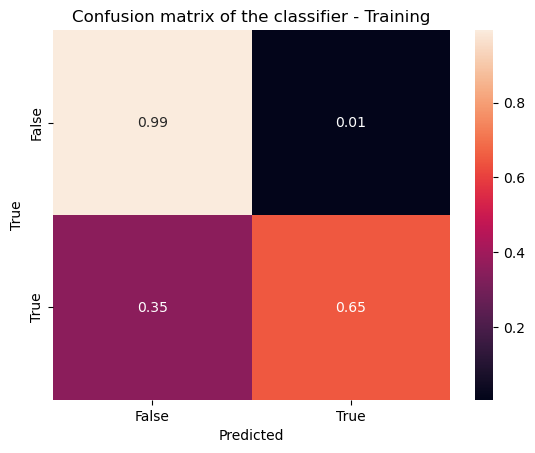

In [40]:
# Generate predictions for the training set
train_preds_roi_class = model_roi_class.predict(X_train_roi)
train_preds_roi_class = train_preds_roi_class == 'True'
print(classification_report(y_train_roi_class, train_preds_roi_class))

# Compute the confusion matrix
cm = confusion_matrix(y_train_roi_class, train_preds_roi_class)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Use seaborn to plot the heatmap
plt.figure()
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[False, True], yticklabels=[False, True])
plt.title('Confusion matrix of the classifier - Training')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


True Negative (TN): This is located at the top-left of the matrix. This value shows the number of instances that were actually False and the model also successfully predicted as False.

False Positive (FP): This is located at the top-right of the matrix. This value shows the number of instances that were actually False, but the model incorrectly predicted as True.

False Negative (FN): This is located at the bottom-left of the matrix. This value shows the number of instances that were actually True, but the model incorrectly predicted as False.

True Positive (TP): This is located at the bottom-right of the matrix. This value shows the number of instances that were actually True and the model also successfully predicted as True.

### Validation performance 

              precision    recall  f1-score   support

       False       1.00      0.98      0.99    170085
        True       0.37      0.77      0.50      2255

    accuracy                           0.98    172340
   macro avg       0.68      0.88      0.75    172340
weighted avg       0.99      0.98      0.98    172340



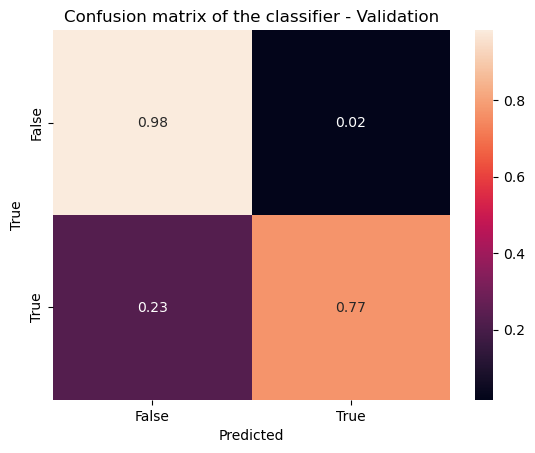

In [41]:
val_preds_roi_class = model_roi_class.predict(X_val_roi)
val_preds_roi_class = val_preds_roi_class == 'True'
print(classification_report(y_val_roi_class, val_preds_roi_class))

# Compute the confusion matrix
cm = confusion_matrix(y_val_roi_class, val_preds_roi_class)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Use seaborn to plot the heatmap
plt.figure()
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[False, True], yticklabels=[False, True])
plt.title('Confusion matrix of the classifier - Validation')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()



## Feature Importance

In [42]:
# Get feature importance
feature_importance = model_roi_class.get_feature_importance()

# Create a pandas dataframe to hold the feature names and their corresponding importance values
feature_importance_df = pd.DataFrame(list(zip(X_train_roi.columns, feature_importance)), 
                                      columns=['Feature', 'Importance'])

# Sort the dataframe based on the feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the dataframe
feature_importance_df

,Feature,Importance
1,Clicks,15.678063
8,ROI_RollingAvg,13.259796
4,CpcBid,12.961277
6,DaysUntilNextPayday,11.894221
3,DayOfWeek,11.781333
7,Count_Achieved_ROI,10.756695
5,DaysUntilNextHoliday,10.420476
2,Month,8.507070
0,KeywordId,4.741069


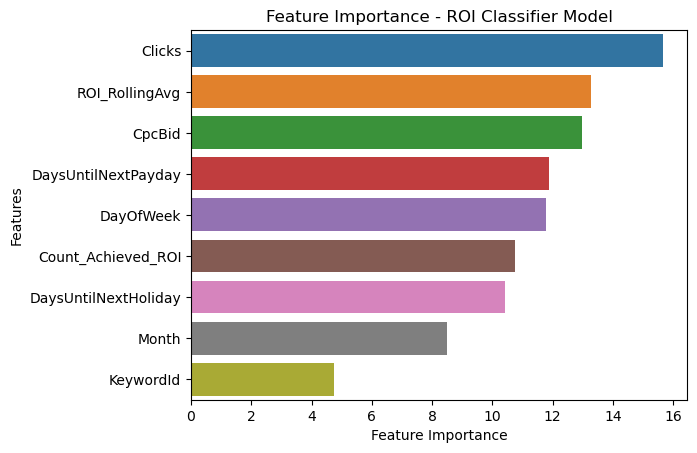

In [43]:
# Plot feature importance
plt.figure()
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - ROI Classifier Model')
plt.show()

### Hyperparameter Tuning 

Log - Find range for search
- Experiment 1: Best Hyperparameters: {'iterations': 581, 'depth': 16, 'learning_rate': 0.48842508376591615}
    - Objective is maximise recall
- Experiment 2: Iterations: 1000, depth = 5 Learning rate = 0.9
     - add new features number of days it has achieved target and moving average of ROI

In [ ]:

trial = 10

class TqdmCallback:
    def __init__(self, total_trials):
        self.pbar = tqdm(total=total_trials)

    def __call__(self, study, trial):
        self.pbar.update()

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 400, 600),
        'depth': trial.suggest_int('depth', 8, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.3, 0.7),
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_roi, y_train_roi_class, cat_features=cat_features, verbose=False)

    train_preds_roi = model.predict(X_train_roi)
    train_preds_roi = train_preds_roi == 'True'  # convert to boolean
    recall_train_roi = recall_score(y_train_roi_class, train_preds_roi)

    return 1 - recall_train_roi  # Optuna tries to minimize the returned value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=trial, callbacks=[TqdmCallback(total_trials=trial)])

best_params = study.best_params
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_roi, y_train_roi_class, cat_features=cat_features)

train_preds_roi = best_model.predict(X_train_roi)
train_preds_roi = train_preds_roi == 'True'  # convert to boolean

val_preds_roi = best_model.predict(X_val_roi)
val_preds_roi = val_preds_roi == 'True'  # convert to boolean

recall_train_roi = recall_score(y_train_roi_class, train_preds_roi)
recall_val_roi = recall_score(y_val_roi_class, val_preds_roi)

print(f"Best Hyperparameters: {best_params}")
print(f"Recall Score (ROI - Training): {recall_train_roi}")
print(f"Recall Score (ROI - Validation): {recall_val_roi}")

# Save best model
best_model.save_model("best_roi_class_model.cbm")


In [ ]:
# Load the saved model
model_roi_class = CatBoostClassifier()
model_roi_class.load_model('best_roi_class_model.cbm')

# Click and ROI Model Evaluation

### Click Prediction

c.f.

Root Mean Squared Error (Clicks - Training): 7.153932182165673

Root Mean Squared Error (Clicks - Validation): 7.6146405065756975

In [ ]:
# Get predictions for test set
test_preds_clicks = model_clicks.predict(X_test_clicks)

# Replace negative predicted click values with zero
test_preds_clicks = np.where(test_preds_clicks < 0, 0, test_preds_clicks)

# Calculate RMSE for Clicks - Test
rmse_test_clicks = np.sqrt(mean_squared_error(y_test_clicks, test_preds_clicks))
print(f"Root Mean Squared Error (Clicks - Test): {rmse_test_clicks}")

# Calculate R2 for test set
r2_test_clicks = r2_score(y_test_clicks, test_preds_clicks)
print(f"R-squared (Clicks - Test): {r2_test_clicks}")

# Plot actual vs predicted Clicks for test set
plt.figure()
plt.scatter(y_test_clicks, test_preds_clicks, alpha=0.3)
plt.plot([0,2500], [0,2500], 'k--', lw=1)
plt.xlabel('Actual Clicks - Test')
plt.ylabel('Predicted Clicks - Test')
plt.title('Actual vs Predicted Clicks - Test')
plt.xlim(0, 2500)
plt.ylim(0, 2500)

# Add text box with RMSE and R2
textstr = '\n'.join((
    r'$RMSE=%.2f$' % (rmse_test_clicks, ),
    r'$R^2=%.2f$' % (r2_test_clicks, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Display plot
plt.show()

# Calculate residuals
residuals_clicks = y_test_clicks - test_preds_clicks

# Calculate mean and standard deviation of residuals
mu = np.mean(residuals_clicks)
std = np.std(residuals_clicks)

# Create histogram
plt.figure()
plt.hist(residuals_clicks, bins=100, alpha=0.3, log=True)
plt.xlabel('Residuals')
plt.ylabel('Log Frequency')
plt.title('Histogram of Residuals')
plt.xlim(-700, 700)

# Add text box with mean and standard deviation
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (std, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Display plot
plt.show()



In [ ]:
# df of test data
# Create a DataFrame for the test set clicks
df_test_clicks = X_test_clicks_plot.copy()

# Convert predicted clicks to integers
predicted_clicks_int = np.round(test_preds_clicks).astype(int)

# Add the actual and predicted clicks to the DataFrame
df_test_clicks['actual_clicks'] = y_test_clicks
df_test_clicks['predicted_clicks'] = predicted_clicks_int

# Assuming df_test_clicks has 'Date' column
df_test_clicks['Date'] = pd.to_datetime(df_test_clicks['Date'])

# Group by 'Date' and sum 'actual_clicks' and 'predicted_clicks'
df_daily_clicks = df_test_clicks.groupby('Date')[['actual_clicks', 'predicted_clicks']].sum(numeric_only=True)

# Plot the sum of 'actual_clicks' and 'predicted_clicks' over time
df_daily_clicks.plot(kind='line', figsize=(12,6))
plt.title('Actual vs Predicted: Sum of Clicks Over Time')
plt.xlabel('Date')
plt.ylabel('Sum of Clicks')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Assuming df_daily_clicks is already sorted by date
df_daily_clicks = df_daily_clicks.sort_values(by='Date')

# Create a figure
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df_daily_clicks.index, y=df_daily_clicks['actual_clicks'],
                    mode='lines',
                    name='actual clicks'))

fig.add_trace(go.Scatter(x=df_daily_clicks.index, y=df_daily_clicks['predicted_clicks'],
                    mode='lines',
                    name='predicted clicks'))

# Add frames
frames=[go.Frame(data=[go.Scatter(
    x=df_daily_clicks.index[:k+1],
    y=df_daily_clicks['actual_clicks'][:k+1],
    mode='lines'),
    go.Scatter(
    x=df_daily_clicks.index[:k+1],
    y=df_daily_clicks['predicted_clicks'][:k+1],
    mode='lines')
]) for k in range(1, len(df_daily_clicks))]

fig.frames = frames

# Add animation configuration
animation_settings = dict(frame=dict(duration=500, redraw=True),
                          fromcurrent=True,
                          transition=dict(duration=300, easing='quadratic-in-out'))

fig.update_layout(updatemenus=[dict(type="buttons",
                                    showactive=False,
                                    buttons=[dict(label="Play",
                                                  method="animate",
                                                  args=[None, animation_settings])])])

# Show figure
fig.show()



In [ ]:
# Get predictions for the test set
test_preds_roi_class = model_roi_class.predict(X_test_roi)
test_preds_roi_class = test_preds_roi_class == 'True'
print(classification_report(y_test_roi_class, test_preds_roi_class))

# Compute the confusion matrix
cm = confusion_matrix(y_test_roi_class, test_preds_roi_class)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate true positive inputs
true_positive_indices = np.where((test_preds_roi_class == True) & (y_test_roi_class == True))[0]
true_positive_inputs = X_test_roi.iloc[true_positive_indices]

# Convert predicted values to a pandas Series (ensure we have the right index)
test_preds_roi_class_series = pd.Series(test_preds_roi_class, index=X_test_roi.index)

# Combine input features, actual target, and predicted target in one dataframe
df_combined = pd.concat([X_test_roi_plot, y_test_roi_class.rename('actual'), test_preds_roi_class_series.rename('predicted')], axis=1)

# Use seaborn to plot the heatmap
plt.figure()
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[False, True], yticklabels=[False, True])
plt.title('Confusion matrix of the classifier - Test')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [ ]:
# Convert the 'Date' column to datetime
df_combined['Date'] = pd.to_datetime(df_combined['Date'])

# Set 'Date' as the index
df_combined.set_index('Date', inplace=True)

# For each day, count the number of unique 'KeywordId's that achieved the target ROI
df_actual = df_combined[df_combined['actual'] == True].groupby('Date')['KeywordId'].nunique()
df_predicted = df_combined[df_combined['predicted'] == True].groupby('Date')['KeywordId'].nunique()

# Create a new DataFrame to store the actual and predicted counts
df_daily = pd.DataFrame()
df_daily['actual'] = df_actual
df_daily['predicted'] = df_predicted

# Plot the actual and predicted counts of 'KeywordId's over time
df_daily[['actual', 'predicted']].plot(kind='line', figsize=(12,6))
plt.title('Actual vs Predicted: Number of Unique KeywordId that Achieved the Target ROI Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Assuming df_daily is already sorted by date
df_daily = df_daily.sort_values(by='Date')

# Create a figure
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily['actual'],
                    mode='lines',
                    name='actual'))

fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily['predicted'],
                    mode='lines',
                    name='predicted'))

# Add frames
frames=[go.Frame(data=[go.Scatter(
    x=df_daily.index[:k+1],
    y=df_daily['actual'][:k+1],
    mode='lines'),
    go.Scatter(
    x=df_daily.index[:k+1],
    y=df_daily['predicted'][:k+1],
    mode='lines')
]) for k in range(1, len(df_daily))]

fig.frames = frames

# Add animation configuration
animation_settings = dict(frame=dict(duration=500, redraw=True),
                          fromcurrent=True,
                          transition=dict(duration=300, easing='quadratic-in-out'))

fig.update_layout(updatemenus=[dict(type="buttons",
                                    showactive=False,
                                    buttons=[dict(label="Play",
                                                  method="animate",
                                                  args=[None, animation_settings])])])

# Show figure
fig.show()


# Bidding Engine Development

Step 1: Read the data from a file   

Step 2: Data preprocessing function 

Step 3: Apply bid optimisation strategy

Step 4: Next day bid prediction

In [ ]:
# Load models

#Clicks 
model_clicks = CatBoostRegressor()
model_clicks.load_model('click_modelv1.cbm')

#ROI
model_roi_class = CatBoostClassifier()
model_roi_class.load_model('roi_class_model.cbm')

### Bid range 

In [ ]:


def days_until_next_holiday(row_date):
    date = row_date.date()  # convert Timestamp to datetime.date
    future_holidays = [d for d in uk_holidays.keys() if d > date]
    if future_holidays:  # check if there is any future holiday
        next_holiday = min(future_holidays)
        return (next_holiday - date).days
    else:
        return np.nan

def days_until_next_payday(row_date):
    # Last business day of the month
    last_business_day = row_date + BMonthEnd(1)
    return (last_business_day - row_date).days




def create_bid_range_df(keyword_id, std, model_clicks, model_roi_class, df, forecast_date):
    # Filter the dataframe for the specified keyword_id
    keyword_df = df[df['KeywordId'] == keyword_id]

    if keyword_df.empty:
        print(f"No data found for keyword_id: {keyword_id}")
        return None, keyword_id, np.nan, np.nan

    # Get the latest CPC bid for the keyword_id
    latest_cpc_bid = keyword_df['CpcBid'].iloc[-1]

    # Create an array of bid values ranging from (latestCpcBid-std) to (latest_cpc_bid+std) with a step of 0.1
    bid_range = np.arange(max(latest_cpc_bid - std, 0), latest_cpc_bid + std + 0.1, 0.1)

    # Create a dataframe to store the bid range and predictions
    df_bid_range = pd.DataFrame({'CpcBid': bid_range})

    # Add the KeywordId column with the specified keyword_id
    df_bid_range['KeywordId'] = keyword_id

    # Add the Clicks and ROITarget columns
    df_bid_range['Clicks'] = np.nan
    df_bid_range['ROITarget'] = np.nan

    # Extract the latest values from the original dataframe (df)
    latest_values = keyword_df.iloc[-1]

    
    # Extract the date of the latest values
    latest_date = latest_values['Date']
    
    # Convert the forecast_date string to a Timestamp object
    forecast_date = pd.Timestamp(forecast_date)

    # Failsafe check for forecast_date and latest_date
    if (forecast_date - latest_date).days > 1:
        print("Input file error: require latest file closer to forecast date")
        return None, keyword_id, latest_cpc_bid, forecast_date, latest_date
    
    # Generate UK holidays for the relevant years
    uk_holidays = holidays.UK(years=list(range(df['Date'].dt.year.min(), df['Date'].dt.year.max() + 1)))

    # Calculate days until next holiday and payday
    days_to_next_holiday = days_until_next_holiday(forecast_date, uk_holidays)
    days_to_next_payday = days_until_next_payday(forecast_date)
    
    

    
    # Extract month and day of the week
    month = forecast_date.month
    day_of_week = forecast_date.weekday()  # Monday is 0, Sunday is 6



    # Common features for clicks and ROI models
    absolute_top_impression_percentage_rolling_avg = latest_values['AbsoluteTopImpressionPercentage_RollingAvg']
    top_impression_percentage_rolling_avg = latest_values['TopImpressionPercentage_RollingAvg']
    search_impression_share_rolling_avg = latest_values['SearchImpressionShare_RollingAvg']
    impressions_rolling_avg = latest_values['Impressions_RollingAvg']
    broad_search = latest_values['BroadSearch']
    roi_rolling_avg = latest_values['ROI_RollingAvg']
    
    # Create the constant parts of the input dataframes for the clicks and ROI models
    clicks_input_constant = pd.DataFrame({
        'KeywordId': [keyword_id],
        'Month': [month],
        'DayOfWeek': [day_of_week],
        'DaysUntilNextHoliday': [days_to_next_holiday],
        'DaysUntilNextPayday': [days_to_next_payday],
        'AbsoluteTopImpressionPercentage_RollingAvg': [absolute_top_impression_percentage_rolling_avg],
        'TopImpressionPercentage_RollingAvg': [top_impression_percentage_rolling_avg],
        'SearchImpressionShare_RollingAvg': [search_impression_share_rolling_avg],
        'Impressions_RollingAvg': [impressions_rolling_avg],
        'BroadSearch': [broad_search]
    })

    roi_input_constant = pd.DataFrame({
        'KeywordId': [keyword_id],
        'Month': [month],
        'DayOfWeek': [day_of_week],
        'DaysUntilNextHoliday': [days_to_next_holiday],
        'DaysUntilNextPayday': [days_to_next_payday],
        'ROI_RollingAvg': [roi_rolling_avg],
        'Count_Achieved_ROI': [latest_values.get('Count_Achieved_ROI', np.nan)] 
    })

    # Make predictions for each bid in the range
    for i, row in df_bid_range.iterrows():
        cpc_bid = row['CpcBid']

        # Append the variable part to the input dataframe for the clicks model
        clicks_input = clicks_input_constant.copy()
        clicks_input['CpcBid'] = cpc_bid

        # Make predictions for clicks
        clicks_prediction = np.round(model_clicks.predict(clicks_input)).astype(int)
        clicks_prediction = np.maximum(clicks_prediction, 0)  # set negative predictions to 0



        df_bid_range.at[i, 'Clicks'] = clicks_prediction

        # Append the variable parts to the input dataframe for the ROI model
        roi_input = roi_input_constant.copy()
        roi_input['CpcBid'] = cpc_bid
        roi_input['Clicks'] = clicks_prediction

        # Make predictions for ROI
        roi_prediction = model_roi_class.predict(roi_input)
        df_bid_range.at[i, 'ROITarget'] = roi_prediction[0]

    return df_bid_range, keyword_id, latest_cpc_bid, forecast_date, latest_date



In [ ]:
df_bid_range

### Solution finder

In [ ]:
# Solution finder for bid range
def determine_best_bid_solution(df_bid_range, keyword_id, previous_CpcBid, forecast_date, latest_date):
    
    # Check if there are any solutions that achieved the ROI target
    solutions_found = (df_bid_range['ROITarget'] == True).sum() > 0
    recommended_CpcBid = 0
    predicted_clicks = 0

    if solutions_found:
        # Filter the dataframe for solutions that achieved the ROI target
        solutions_roi_target = df_bid_range[df_bid_range['ROITarget'] == True]

        # Determine the solution with the most clicks
        max_clicks = solutions_roi_target['Clicks'].max()
        best_solution_clicks = solutions_roi_target[solutions_roi_target['Clicks'] == max_clicks]

        if len(best_solution_clicks) > 1:
            # If multiple solutions have the same number of clicks, choose the one with the cheapest bid
            min_bid = best_solution_clicks['CpcBid'].min()
            best_solution = best_solution_clicks[best_solution_clicks['CpcBid'] == min_bid].iloc[0]
        else:
            # Only one solution with the most clicks
            best_solution = best_solution_clicks.iloc[0]

        # Extract the recommended bid and predicted clicks from the best solution
        recommended_CpcBid = best_solution['CpcBid']
        predicted_clicks = best_solution['Clicks']

    # Create a new dataframe with the bid file information
    bid_file_df = pd.DataFrame({
        'KeywordID': [keyword_id],
        'Forecast_Date': [forecast_date],
        'Solution_Found': [solutions_found],
        'Recommended_CpcBid': [recommended_CpcBid],
        'Predicted_Clicks': [predicted_clicks],
        'Previous_CpcBid_Date': [latest_date],
        'Previous_CpcBid': [previous_CpcBid],
    })

    return bid_file_df

### Single keyword

In [ ]:
# Load models
model_clicks = CatBoostRegressor()
model_clicks.load_model('click_modelv1.cbm')

model_roi_class = CatBoostClassifier()
model_roi_class.load_model('roi_class_model.cbm')

# Input
std = 2
keyword_id = '1058788934121'
df = df
forecast_date = '2023-06-0'


# Call the create_bid_range_df function
df_bid_range, keyword_id, previous_CpcBid, forecast_date, latest_date = create_bid_range_df(keyword_id, std, model_clicks, model_roi_class, df, forecast_date)


# Call the determine_best_bid_solution function with the outputs from the create_bid_range_df function
bid_file_df = determine_best_bid_solution(df_bid_range, keyword_id,previous_CpcBid, forecast_date, latest_date)


print(df_bid_range)
print(bid_file_df)

### Apply to all keywords

In [ ]:
# Load models
model_clicks = CatBoostRegressor()
model_clicks.load_model('click_modelv1.cbm')

model_roi_class = CatBoostClassifier()
model_roi_class.load_model('roi_class_model.cbm')

# Input
std = 2
df = df
forecast_date = '2023-06-06'

# Get all unique keyword ids
keyword_ids = df['KeywordId'].unique()

# Initialize an empty list to store the bid files
bid_file_rows = []

for keyword_id in keyword_ids:
    # Call the create_bid_range_df function
    df_bid_range, keyword_id, previous_CpcBid, forecast_date, latest_date = create_bid_range_df(keyword_id, std, model_clicks, model_roi_class, df, forecast_date)
    
    # Check if df_bid_range is not None before proceeding
    if df_bid_range is not None:
        # Call the determine_best_bid_solution function with the outputs from the create_bid_range_df function
        bid_file_row = determine_best_bid_solution(df_bid_range, keyword_id, previous_CpcBid, forecast_date, latest_date)
    
        # Append the row to the bid_file_rows list
        bid_file_rows.append(bid_file_row)
        print(keyword_id)
    else:
        print(f"Skipping {keyword_id} due to lack of data.")

# Concatenate all the bid_file_rows into a single DataFrame
bid_file_df = pd.concat(bid_file_rows, ignore_index=True)

print(bid_file_df)


In [ ]:
bid_file_df['Solution_Found'].value_counts()

## Bid Engine Validation

In [ ]:
# Perform time-based splitting
df_sorted = df.sort_values('Date', ascending=True)

train_size = int(len(df_sorted) * train_frac)
val_size = int(len(df_sorted) * val_frac)
test_size = int(len(df_sorted) * test_frac)

_, _, df_test_split = np.split(df_sorted, [train_size, train_size+val_size])

# Filter DataFrame where 'ROI' achieved the target
filtered_df_test = df_test_split[df_test_split['ROI'] >= 2]

# Group by 'Date' and count unique 'KeywordId'
grouped_df_test = filtered_df_test.groupby('Date')['KeywordId'].nunique()

# Plot the data
plt.figure(figsize=(10,6))
grouped_df_test.plot(kind='line', label='Test data')
plt.xlabel('Date')
plt.ylabel('Number of Unique KeywordId')
plt.title('Number of Unique KeywordId that Achieved the Target ROI Over Time (Test Data)')
plt.ylim(0,80)
plt.legend()
plt.show()


In [ ]:
roi_input =

In [ ]:
model_roi_class.predict(roi_input)